# Step 1

## a. Define each of the 5 factors in the Fama-French 5 model

## b. For each factor, explain how it helps to explain returns

# Step 2

Download daily data from [this site](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) for a timeframe of 3 years

Below, we include all Python package that will be used.

In [1]:
from datetime import datetime, date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.graphics.regressionplots import plot_partregress_grid

plt.rcParams["figure.figsize"] = (16, 9)

import warnings
warnings.filterwarnings('ignore')

## a. Import, structure, and graph the daily factor returns

We begin by importing the ``csv`` file into a ``pandas DataFrame``.

We set our timeframe of observation on the 3-year period that goes from March 1st, 2021 to February 29th, 2024.

In [2]:
# csv to pd.DataFrame
path = "F-F_Research_Data_5_Factors_2x3_daily.csv" # relative path of csv file
df_daily = pd.read_csv(path, header=2, date_format='%Y%m%d', parse_dates=True)#, skipfooter=0, engine="python")

# adapt 1st column to date format in python
df_daily['Unnamed: 0'] = df_daily['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
df_daily = df_daily.rename(columns={'Unnamed: 0': 'Date'})
df_daily = df_daily.set_index('Date')

# 3-year timeframe chosen
start = date(2021, 3, 1)
end = date(2024, 2, 29)
df_daily = df_daily[start: end]

df_daily

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2021-03-01,2.63,1.11,0.23,-0.41,0.23,0.000
2021-03-02,-1.05,-0.77,1.23,0.62,0.20,0.000
2021-03-03,-1.57,0.64,3.56,1.67,1.05,0.000
2021-03-04,-1.70,-1.11,1.71,1.29,0.44,0.000
2021-03-05,1.85,0.36,0.61,0.97,0.51,0.000
...,...,...,...,...,...,...
2024-02-23,0.02,0.32,-0.03,0.09,-0.11,0.021
2024-02-26,-0.26,0.97,-0.11,-0.74,-0.01,0.021
2024-02-27,0.27,1.24,-0.45,-1.14,0.67,0.021


The time series for each of the Fama-French (FF) factors in the timeframe considered are visualised below.

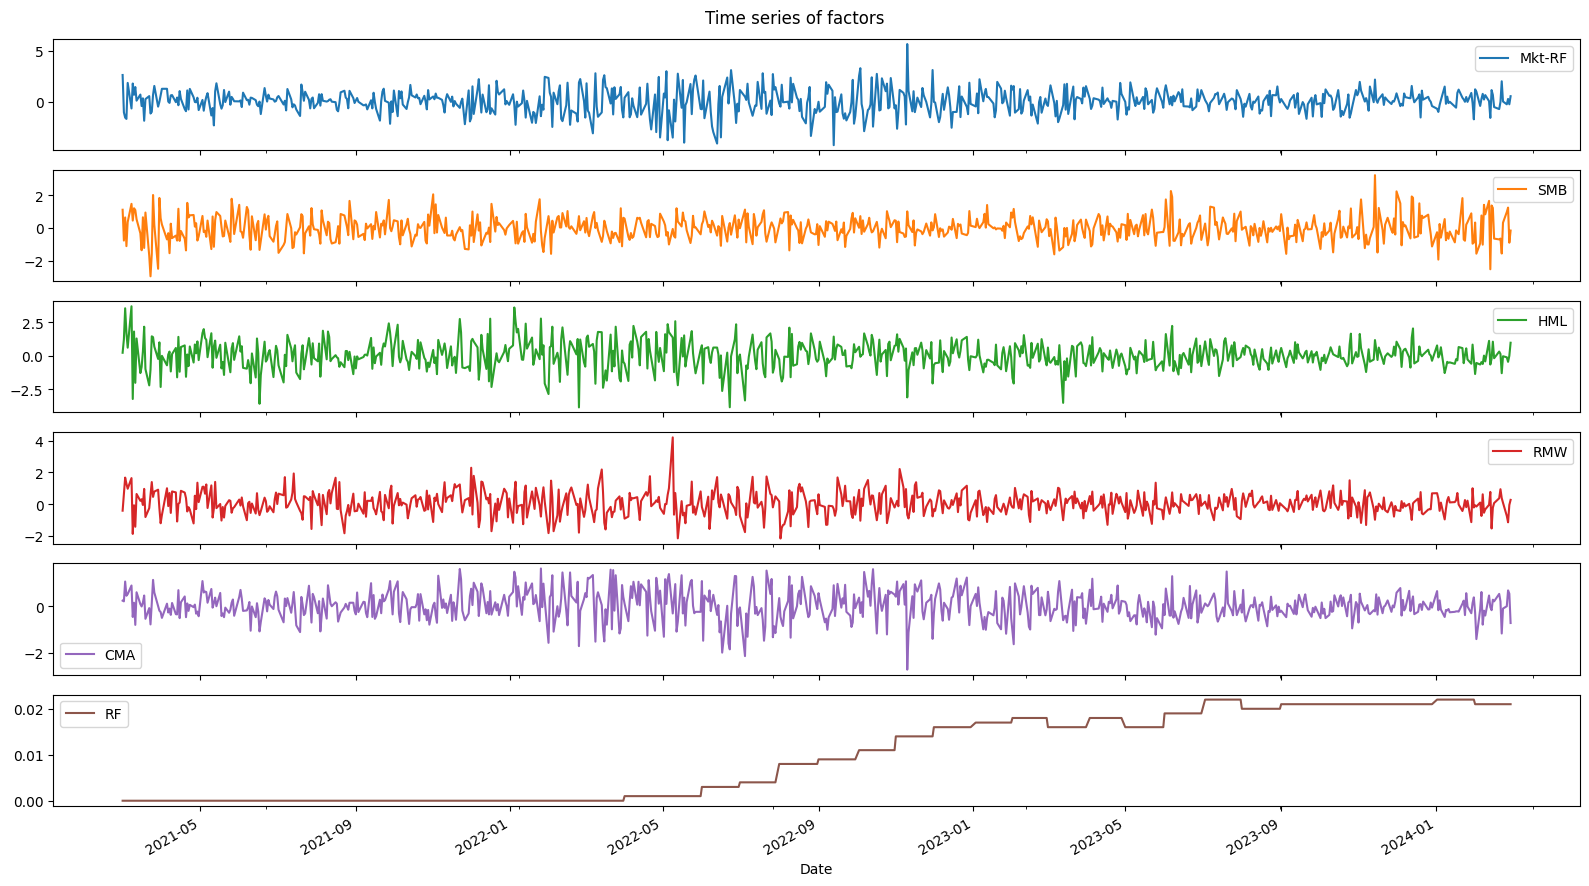

In [3]:
# graph time series of factors
df_daily.plot(subplots=True, title="Time series of factors")
plt.tight_layout()
plt.show()

In [4]:
# maybe add histograms of distributions

Some additional statistics regarding the time series of the 5 FF factors:

In [5]:
df_daily.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.031442,-0.028810,0.029418,0.044471,0.017500,0.009373
std,1.155105,0.721922,1.037161,0.712109,0.619492,0.008988
min,-4.290000,-2.950000,-3.860000,-2.160000,-2.730000,0.000000
25%,-0.652500,-0.500000,-0.580000,-0.380000,-0.352500,0.000000
50%,0.025000,-0.020000,-0.010000,0.040000,0.000000,0.008000
75%,0.710000,0.410000,0.672500,0.510000,0.400000,0.018000
max,5.680000,3.220000,3.710000,4.200000,1.610000,0.022000


## b. Collect and compute correlations of the changes in the factor returns.

As a preliminary to the analysis of their returns, we inspect the daily correlations of the five factors themselves:

In [6]:
df_daily_corr = df_daily.corr()
df_daily_corr

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,1.000000,0.243415,-0.362545,-0.352044,-0.467402,0.026337
SMB,0.243415,1.000000,0.104209,-0.430382,-0.040453,0.003073
HML,-0.362545,0.104209,1.000000,0.434571,0.754853,-0.050252
RMW,-0.352044,-0.430382,0.434571,1.000000,0.389006,-0.044283
CMA,-0.467402,-0.040453,0.754853,0.389006,1.000000,-0.080202
RF,0.026337,0.003073,-0.050252,-0.044283,-0.080202,1.000000


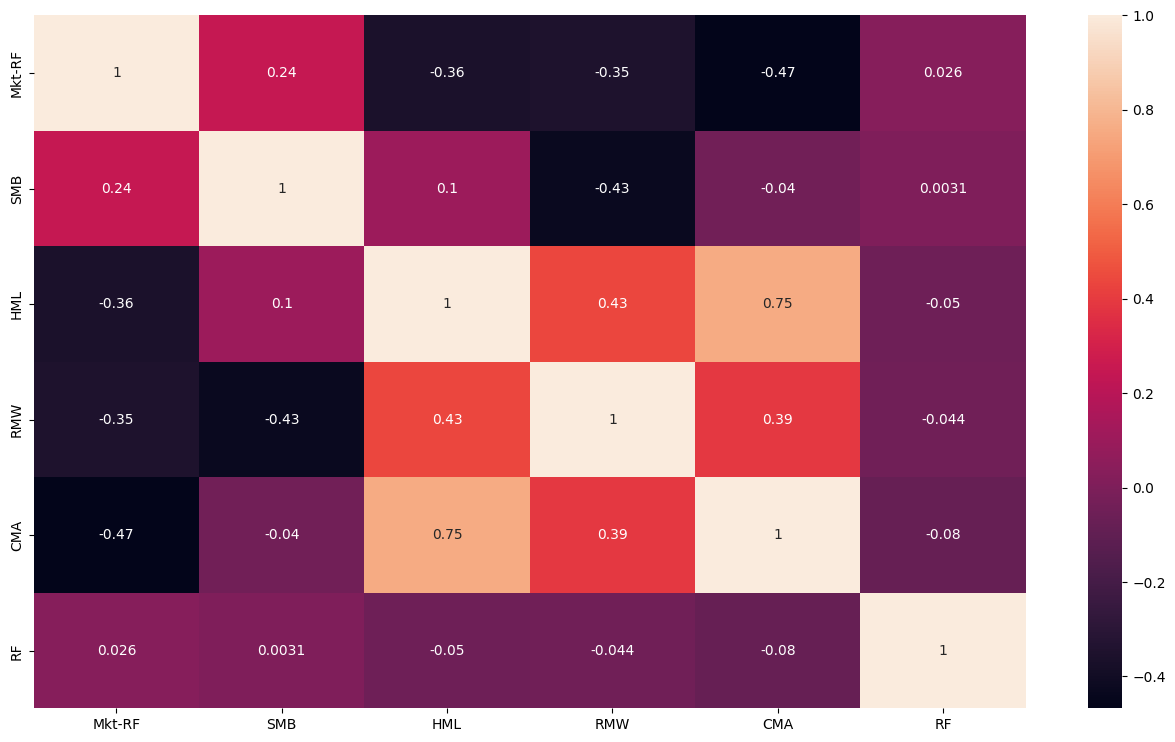

In [7]:
sns.heatmap(df_daily_corr, annot=True)
plt.show()

From the above we can see that almost all of the factors, with the exception of the risk free rate RF, are heavily correlated, either positively or negatively.

The daily factor returns, expressed as percent change with respect to the previous day, are derived as:

In [8]:
factor_returns = df_daily.pct_change()
# drop nan values from 1st line, and set 0/0 divisions to 0.0
factor_returns = factor_returns.drop(start)
factor_returns = factor_returns.where(factor_returns.notna(), 0.0)

factor_returns

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2021-03-02,-1.399240,-1.693694,4.347826,-2.512195,-0.130435,0.0
2021-03-03,0.495238,-1.831169,1.894309,1.693548,4.250000,0.0
2021-03-04,0.082803,-2.734375,-0.519663,-0.227545,-0.580952,0.0
2021-03-05,-2.088235,-1.324324,-0.643275,-0.248062,0.159091,0.0
2021-03-08,-1.362162,3.083333,5.081967,0.690722,0.725490,0.0
...,...,...,...,...,...,...
2024-02-23,-0.990050,-1.205128,-0.976923,-0.763158,-0.906780,0.0
2024-02-26,-14.000000,2.031250,2.666667,-9.222222,-0.909091,0.0
2024-02-27,-2.038462,0.278351,3.090909,0.540541,-68.000000,0.0


Above, 

- we dropped `NaN` values stemming from the first line (that lacks previous reference data) of the DataFrame, and 
- we replaced $\frac{0}{0} = \text{NaN}$, mainly appearing in the RF column when both previous and current daily entries are $= 0$, with $0$.

Plotting the time series of returns yields:

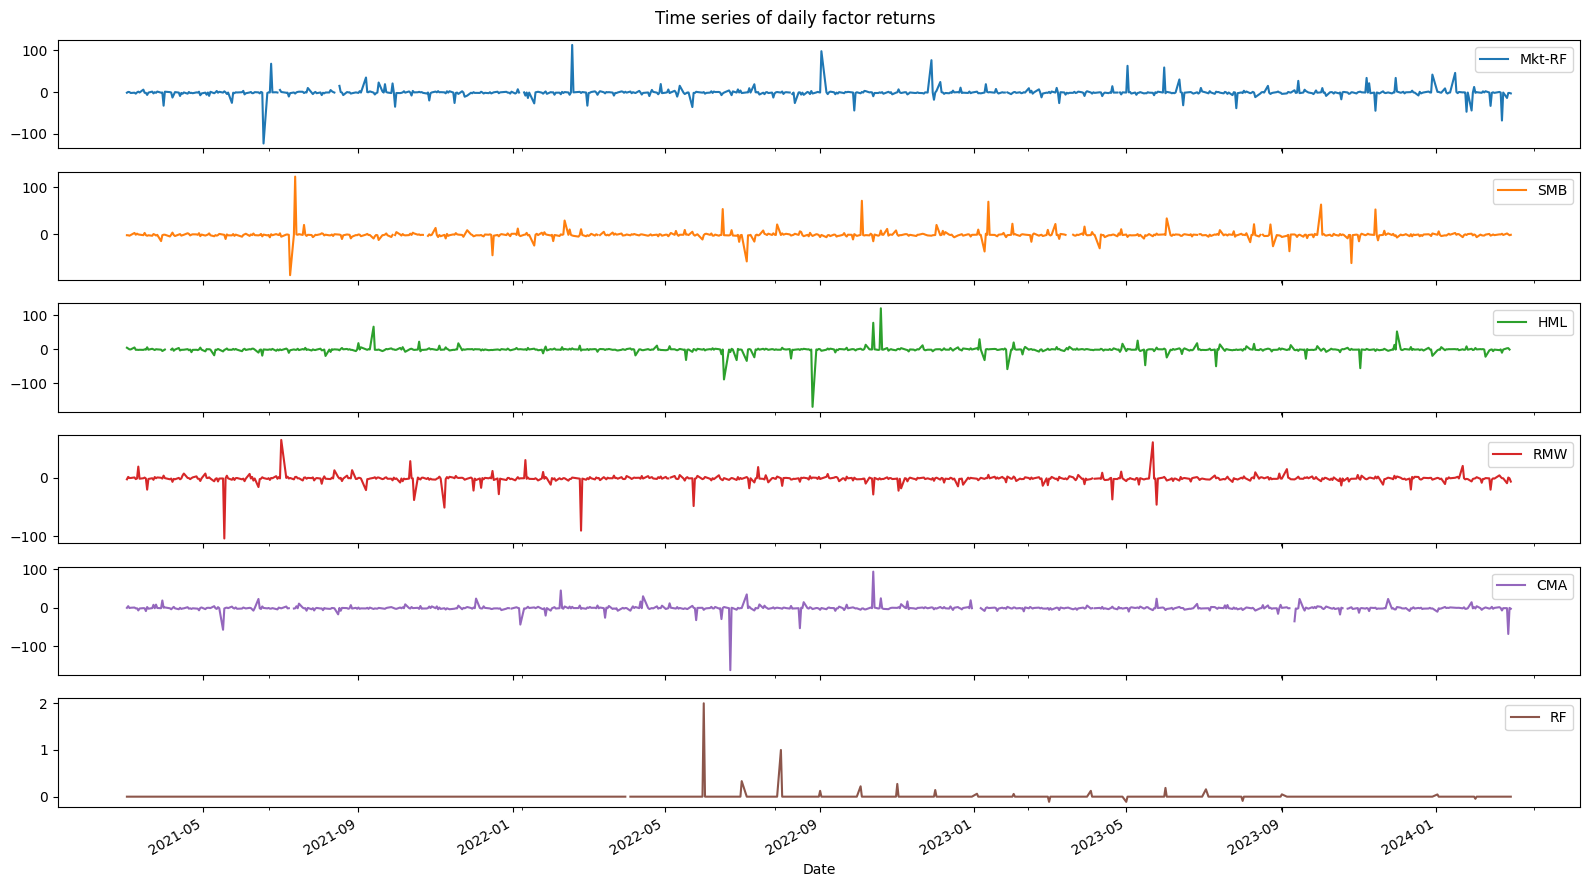

In [9]:
factor_returns.plot(subplots=True, title="Time series of daily factor returns")
plt.tight_layout()
plt.show()

At first glance, the series look fairly stationary.

One can however observe imperfections in most of the graphs, in the form of gaps within plottings (for instance, in the plot for RF at about 2022-04).
These are $- \infty$ or $\infty$ values in the time series originated from dividing from a previous daily value of $0$.
We correct this by setting infinity values to an arbitrarily large number, $\pm 1000$.

In [10]:
# set infinity points to + or - 1000
factor_returns = factor_returns.where(factor_returns != np.inf, 1000.0)
factor_returns = factor_returns.where(factor_returns != -np.inf, -1000.0)

Now we can finally compute the correlation matrix between the five factor returns.

In [11]:
factor_corr = factor_returns.corr()
factor_corr

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,1.000000,-0.002249,0.005137,-0.000859,0.009779,0.000929
SMB,-0.002249,1.000000,-0.002190,-0.001015,-0.011633,0.000715
HML,0.005137,-0.002190,1.000000,0.001019,0.015205,0.001103
RMW,-0.000859,-0.001015,0.001019,1.000000,0.261718,0.001419
CMA,0.009779,-0.011633,0.015205,0.261718,1.000000,-0.002398
RF,0.000929,0.000715,0.001103,0.001419,-0.002398,1.000000


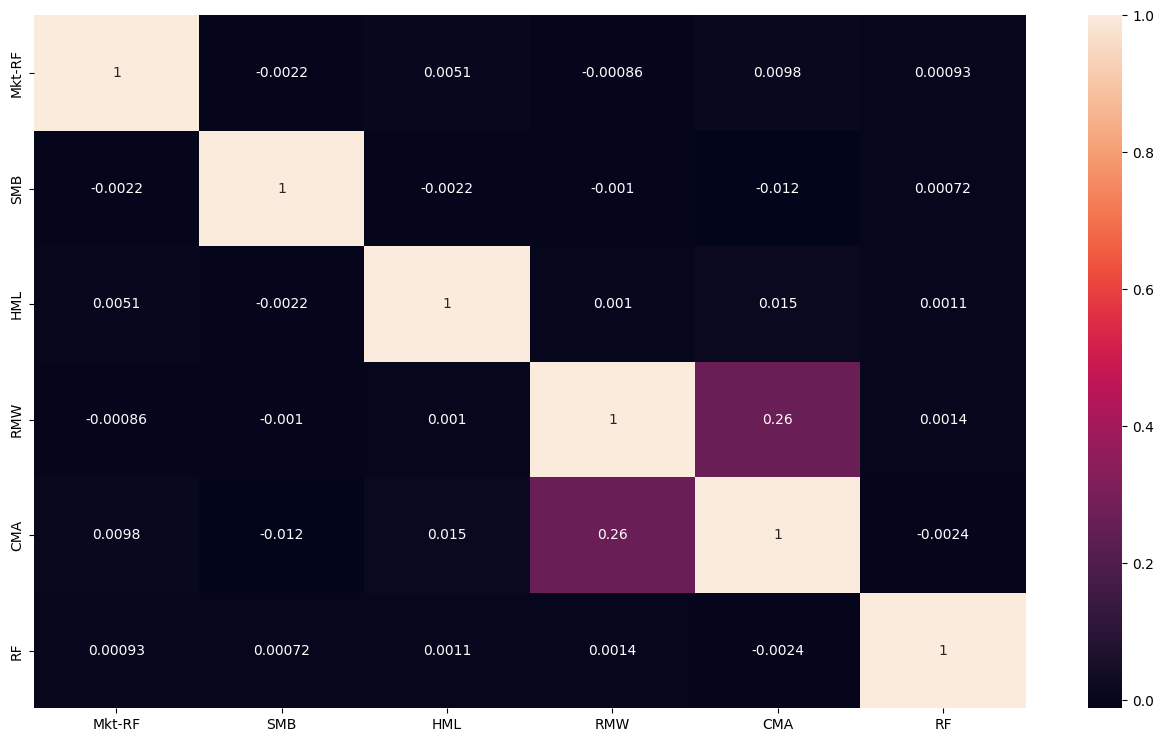

In [12]:
sns.heatmap(factor_corr, annot=True)
plt.show()

The series of first differences of factor returns are uncorrelated, with just one exception of weak correlation between RMW and CMA.

However, for subsequent steps we will rely on the FF3/5 factors themselves, not on their first differences. 
This is because the latter do not lend themselves to be easily interpreted.

## c. Collect economic data of your choice during that 3-year period

As a proxy for risk-free rate, we download from *Yahoo! Finance* data tracking the ^IRX index, which is based on yields from the 13-week US Treasury bills.

In [13]:
tbill_13w = yf.download("^IRX", start, end)
tbill_13w = pd.DataFrame(tbill_13w["Adj Close"])
tbill_13w = tbill_13w.rename(columns={'Adj Close': '^IRX'})
tbill_13w

[*********************100%%**********************]  1 of 1 completed


,^IRX
Date,
2021-03-01,0.028
2021-03-02,0.035
2021-03-03,0.035
2021-03-04,0.028
2021-03-05,0.028
...,...
2024-02-22,5.233
2024-02-23,5.240
2024-02-26,5.250


As could be expected, the graph below shows that this interest rates index increases in value following worldwide inflation due to 
- disruptions in global production and supply of goods and services after the Covid pandemic, and 
- sanctions to Russia which increased costs for raw materials.

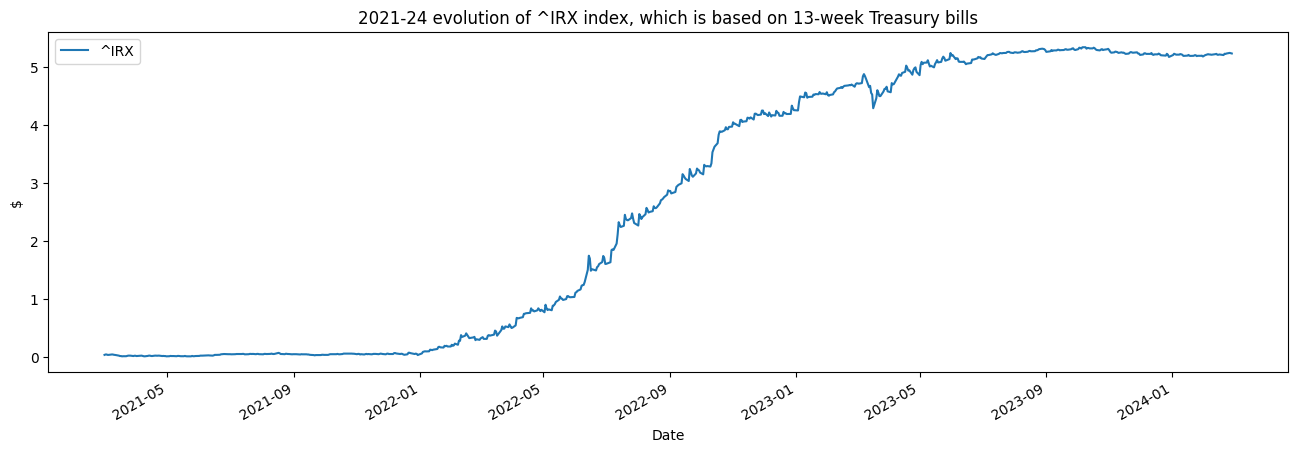

In [14]:
title = "2021-24 evolution of ^IRX index, which is based on 13-week Treasury bills"
tbill_13w.plot(figsize=(16, 5), title=title, ylabel="$")
plt.legend()
plt.show()

# Step 3

Find the betas of factors in the Fama-French 3 model.

## a. Run both Least Squares and robust regressions on the data, and describe the train-test split.

### Least Squares regression

For convenience, as a first step we add the 13-weeks Treasury bill index ^IRX to the ```pandas``` DataFrame of FF3 factors for the timeframe considered, then we plot the data.

In [15]:
df_daily['IRX'] = tbill_13w['^IRX']
#df_daily['^IRX first diff'] = tbill_13w['^IRX'].pct_change()
df_daily = df_daily.dropna()
df_daily

,Mkt-RF,SMB,HML,RMW,CMA,RF,IRX
Date,,,,,,,
2021-03-01,2.63,1.11,0.23,-0.41,0.23,0.000,0.028
2021-03-02,-1.05,-0.77,1.23,0.62,0.20,0.000,0.035
2021-03-03,-1.57,0.64,3.56,1.67,1.05,0.000,0.035
2021-03-04,-1.70,-1.11,1.71,1.29,0.44,0.000,0.028
2021-03-05,1.85,0.36,0.61,0.97,0.51,0.000,0.028
...,...,...,...,...,...,...,...
2024-02-22,2.01,-1.56,-1.30,0.38,-1.18,0.021,5.233
2024-02-23,0.02,0.32,-0.03,0.09,-0.11,0.021,5.240
2024-02-26,-0.26,0.97,-0.11,-0.74,-0.01,0.021,5.250


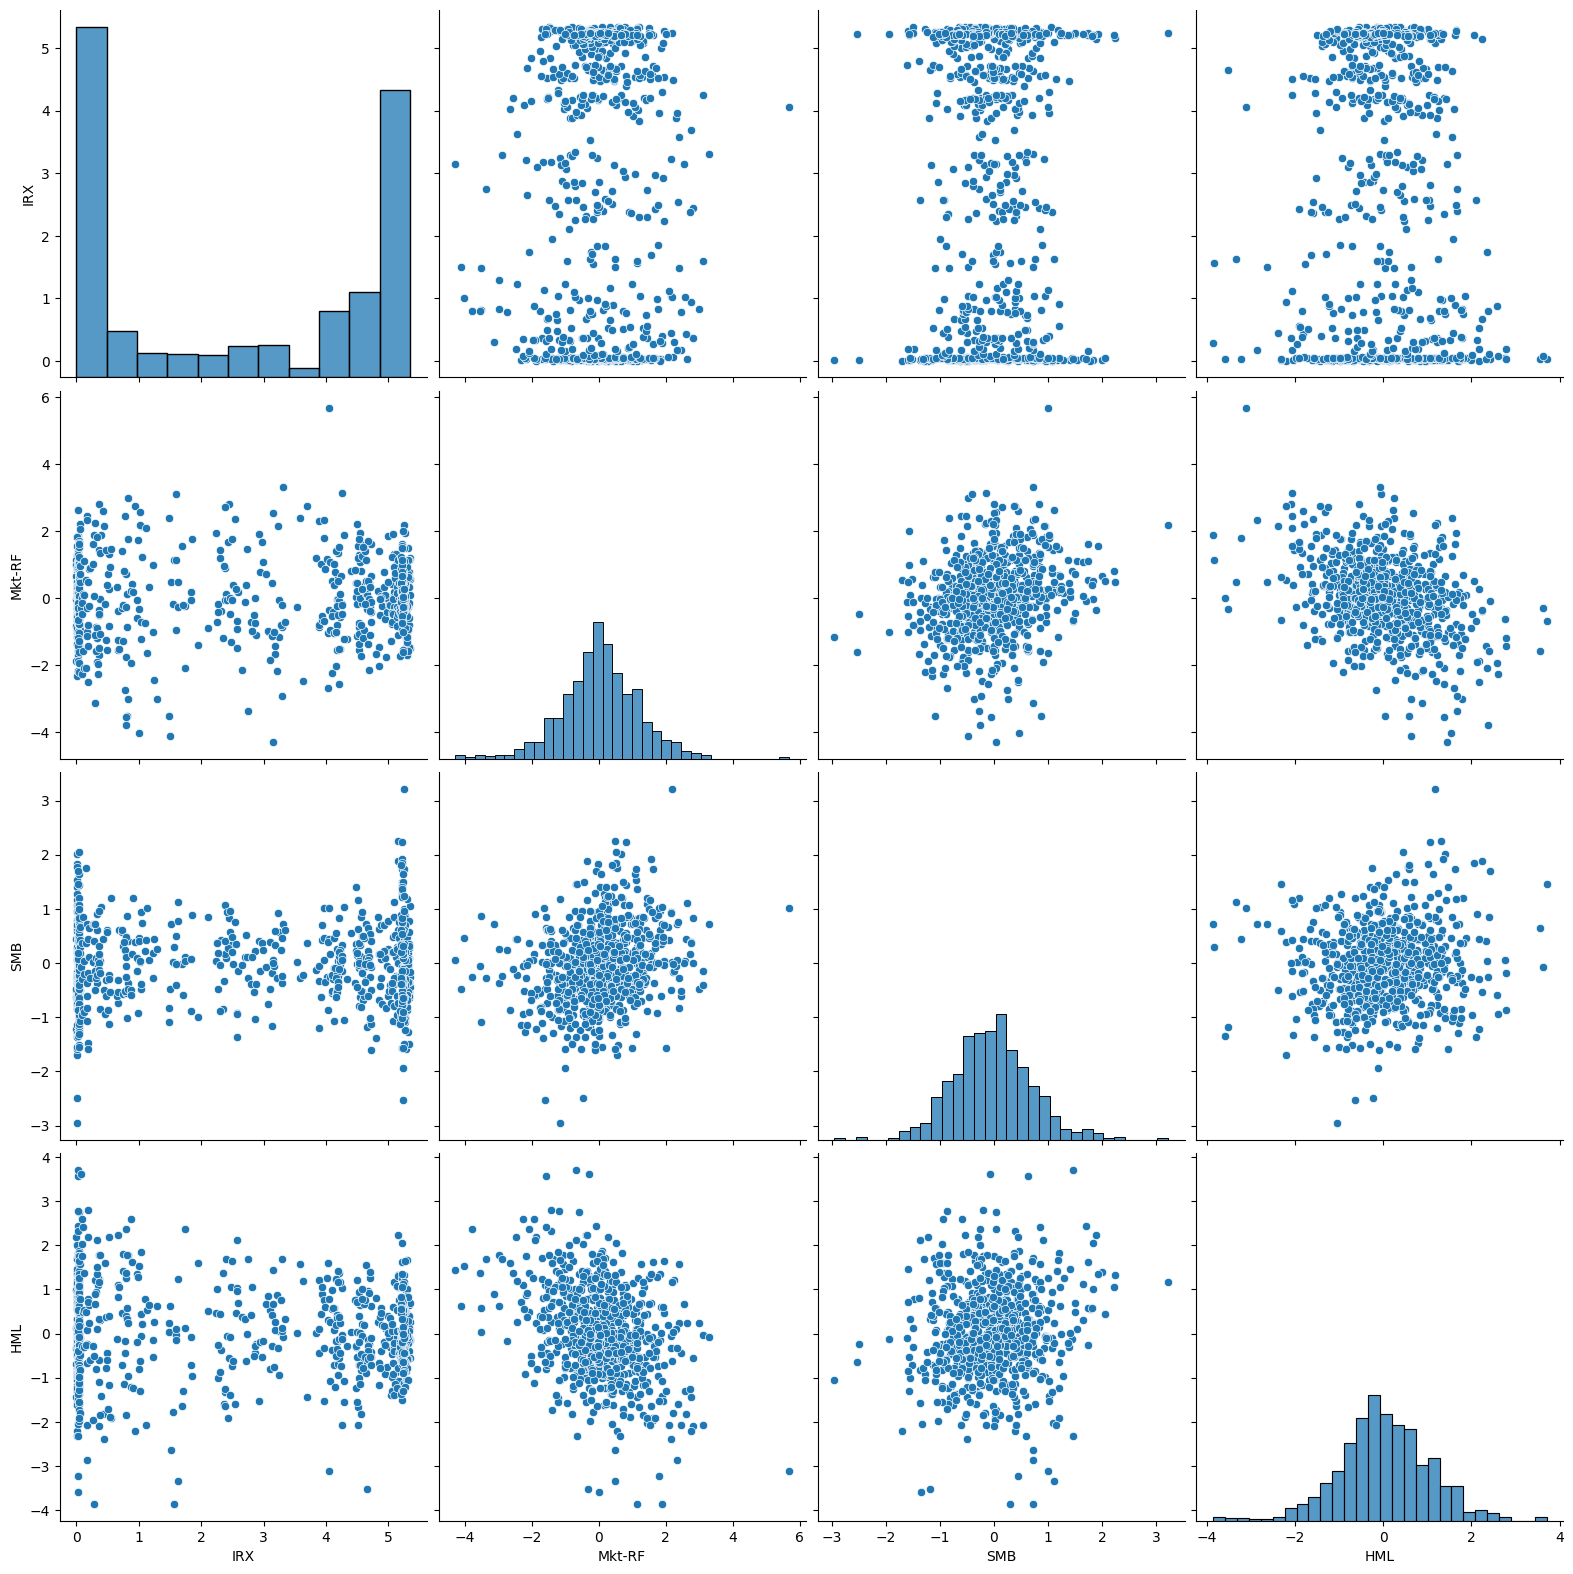

In [16]:
# draw scatterplot
sns.pairplot(df_daily, vars=['IRX', 'Mkt-RF', 'SMB', 'HML'], height=4)

Plots above show graphically how the FF3 factors are correlated among each other, but we can anticipate the dependent variable ^IRX, the Treasury bill rates is largely uncorrelated, i.e. independent from them.

Histograms on the main diagonal of the pairplot show distributions of the variables over the selected 3-year timeframe.
The distribution histogram for ^IRX shows that the dependent variable in our incoming analysis is clearly not normally distributed.

Thus from the correlation and histogram plots above, we have just learned that 
- the dependent and independent variables of the incoming linear regression analysis are not in a linear relationship with each other
- the three factors adopted as independent variables are fairly correlated with one another
- the dependent variable ^IRX is not normally distributed.

These observations lead us to anticipate that the linear regression of ^IRX from the three factors of the Fama-French model will not be successful.

In [17]:
test_ratio = 0.25
test_set = int(test_ratio * len(df_daily))  # Number of observations in the test sample
train_set = len(df_daily) - test_set  # observations in the train sample

In [18]:
# function: splits the database into train and test data
def trainTestSplit(df, ts):
    Xdf, ydf = df.iloc[:,:-1], df.iloc[:,-1]
    X = Xdf.astype("float32")
    y = ydf.astype("float32")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=ts, shuffle=False
    )
    return X_train, X_test, y_train, y_test

In [19]:
factors_FF3 = df_daily[['Mkt-RF', 'SMB', 'HML', 'IRX']]
X_train, X_test, Y_train, Y_test = trainTestSplit(factors_FF3, test_set)

In [20]:
# train the linear regression model ^IRX = f(FF3)
X_train = sm.add_constant(X_train)
linear_regr_3_factors_model = sm.OLS(Y_train, X_train)
linear_regr_3_factors = linear_regr_3_factors_model.fit()
train_params = linear_regr_3_factors.params
linear_regr_3_factors.summary()
# Mkt-RF,SMB,HML,RMW,CMA,RF 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    IRX   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.331
Date:                Fri, 03 May 2024   Prob (F-statistic):              0.263
Time:                        03:40:14   Log-Likelihood:                -1174.4
No. Observations:                 567   AIC:                             2357.
Df Residuals:                     563   BIC:                             2374.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7562      0.081     21.662      0.000       1.597       1.915
Mkt-RF        -0.0516      0.073     -0.706      0.481      -0.195       0.092
SMB            0.0466      0.124      0.375      0.708      -0.198       0.291
HML           -0.1565      0.079     -1.983      0.048      -0.311      -0.001
==============================================================================
Omnibus:                    48424.135   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.664
Skew:                           0.553   Prob(JB):                     6.12e-17
Kurtosis:                       1.608   Cond. No.                         2.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
train_params

const     1.756222
Mkt-RF   -0.051613
SMB       0.046557
HML      -0.156456
dtype: float64

In [22]:
linear_regr_FF3_train = linear_regr_3_factors_model.predict(train_params)#, exog=Y_test)
training_time = df_daily.index[:train_set]
print(len(training_time), len(linear_regr_FF3_train), len(Y_train))

567 567 567


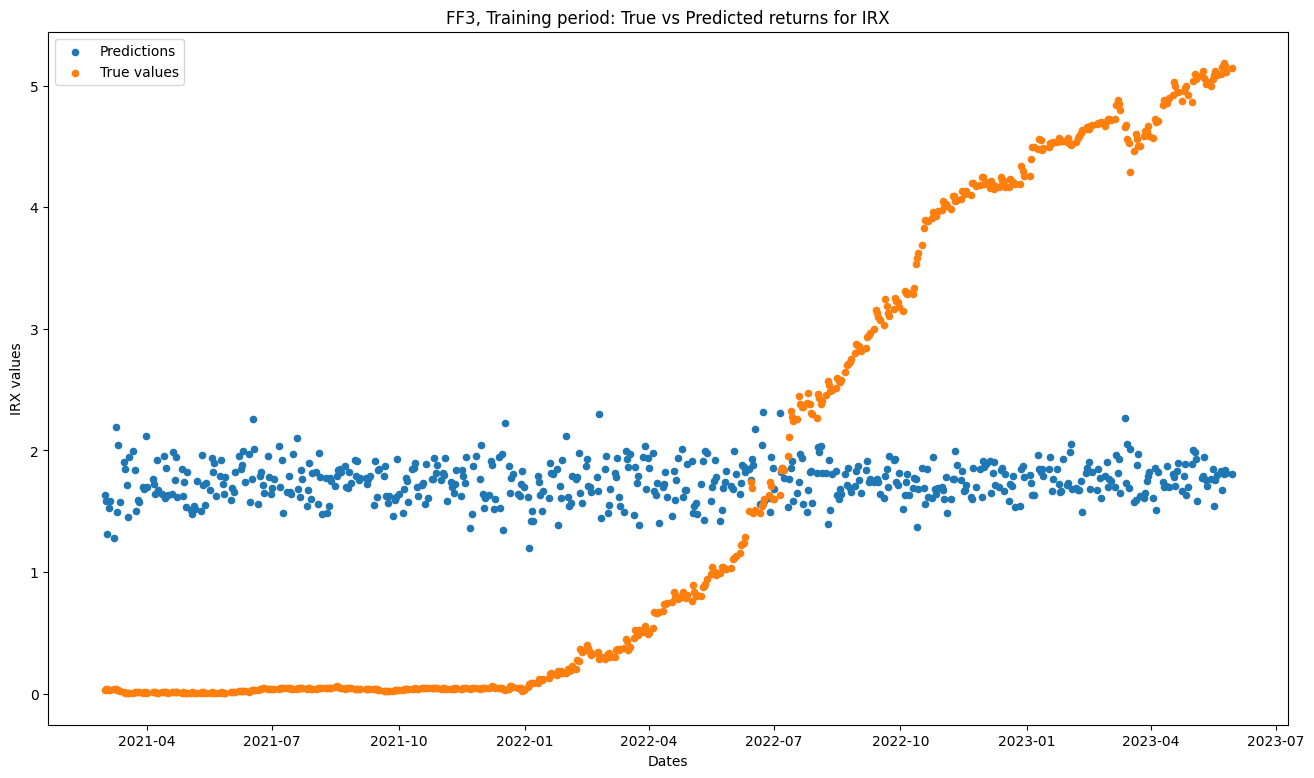

In [23]:
df_training_predictions_FF3 = pd.DataFrame(
    {"Date": training_time, "Predictions": linear_regr_FF3_train, "True values": Y_train}
)

plt.figure()
ax = plt.gca()
df_training_predictions_FF3.plot.scatter(x="Date", y="Predictions", c='tab:blue', label='Predictions', ax=ax)
df_training_predictions_FF3.plot.scatter(x="Date", y="True values", c='tab:orange', label='True values', ax=ax)
# time_on_x = df_training_predictions_FF3["Date"] - df_training_predictions_FF3["Date"].min()#.apply(lambda x: x.date()))#.astype(np.int64)
# time_on_x = time_on_x.astype(np.int64) * 1E-12
# (a, b) = np.polyfit(time_on_x, df_training_predictions_FF3["Predictions"], 1)
# plt.plot(time_on_x, a * time_on_x + b, label="best regression fit line")
ax.set_xlabel('Dates')
ax.set_ylabel("IRX values")
plt.legend()
plt.title("FF3, Training period: True vs Predicted returns for IRX")
plt.show()

In [24]:
linear_regr_FF3_test = linear_regr_3_factors.predict(sm.add_constant(X_test, has_constant='add')) # added alpha coefficient
testing_time = df_daily.index[train_set:]
print(len(testing_time), len(linear_regr_FF3_test), len(Y_test))

188 188 188


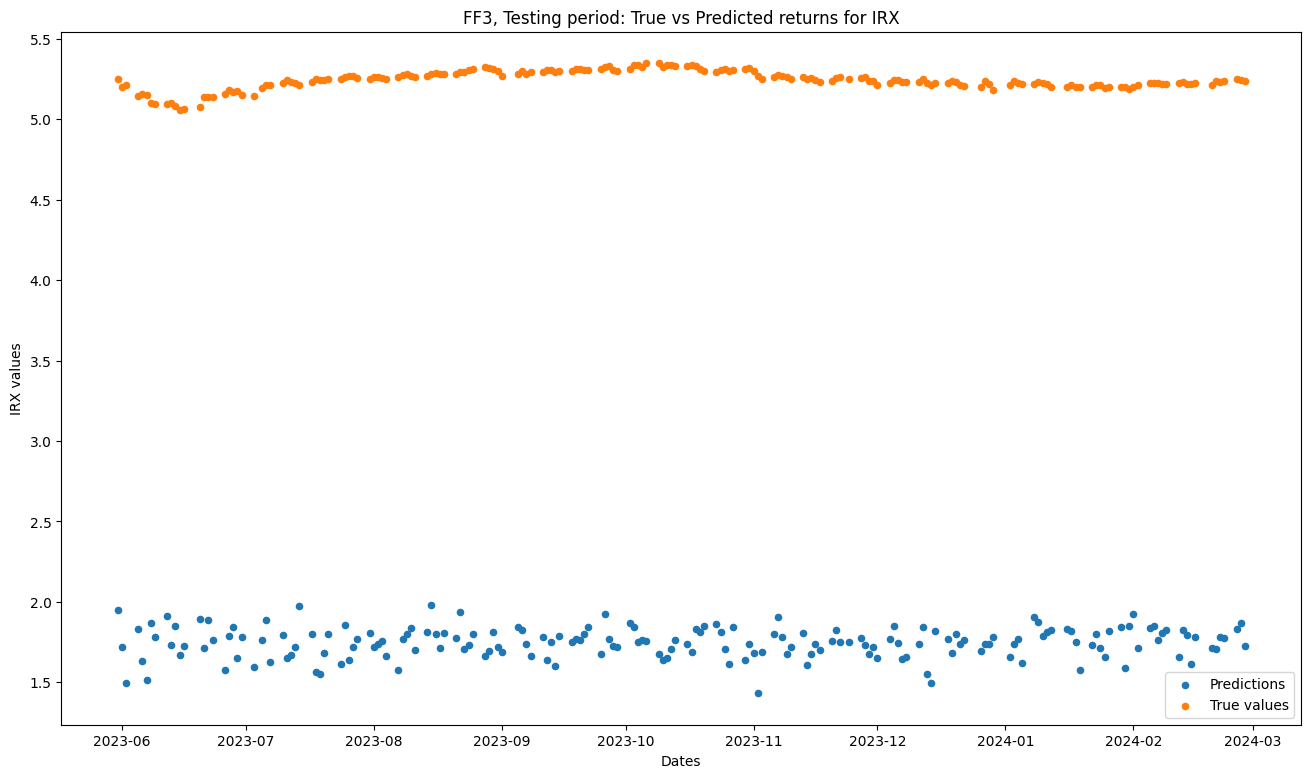

In [25]:
df_testing_predictions_FF3 = pd.DataFrame(
    {"Date": testing_time, "Predictions": linear_regr_FF3_test, "True values": Y_test}
)

plt.figure()
ax = plt.gca()
df_testing_predictions_FF3.plot.scatter(x="Date", y="Predictions", c='tab:blue', label='Predictions', ax=ax)
df_testing_predictions_FF3.plot.scatter(x="Date", y="True values", c='tab:orange', label='True values', ax=ax)
plt.legend()
ax.set_xlabel('Dates')
ax.set_ylabel("IRX values")
plt.title("FF3, Testing period: True vs Predicted returns for IRX")
plt.show()

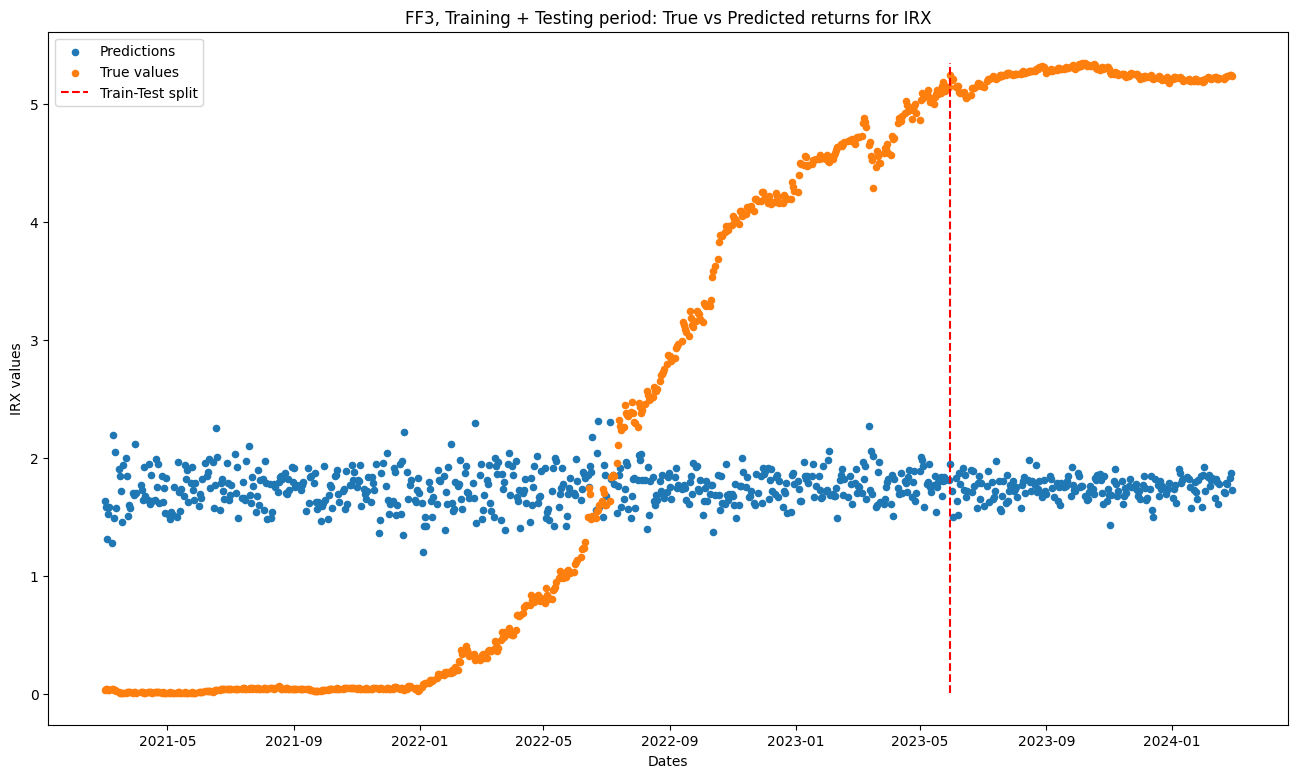

In [26]:
FF3_LS_predictions = pd.concat([df_training_predictions_FF3, df_testing_predictions_FF3],
    keys=['training', 'testing'],
    ignore_index=True                          
)

plt.figure()
ax = plt.gca()
FF3_LS_predictions.plot.scatter(x="Date", y="Predictions", c='tab:blue', label='Predictions', ax=ax)
FF3_LS_predictions.plot.scatter(x="Date", y="True values", c='tab:orange', label='True values', ax=ax)
plt.vlines(x=df_testing_predictions_FF3["Date"].iloc[0], 
           ymin=FF3_LS_predictions["True values"].min(), 
           ymax=FF3_LS_predictions["True values"].max(), 
           colors="r", 
           linestyles="dashed",
           label="Train-Test split")
plt.legend()
ax.set_xlabel('Dates')
ax.set_ylabel("IRX values")
plt.title("FF3, Training + Testing period: True vs Predicted returns for IRX")
plt.show()

We see that the ordinary least squares (OLS) linear regression of ^IRX from the FF3 factors yields high to very high *p*-values for the estimates of the coefficients $\beta_i$, $i= 1,\, 2, \, 3$.
This is true not only inside the testing period, but for the training period as well.

This means that none of the factors can explain the variation of the dependent variable ^IRX.
Another indication that the OLS regression just performed is not significant is given by the very low value of the $R^2$ statistic which is practically $\sim 0$.

Below, for this model we plot the partial regression lines of the dependent variable, ^IDX, against each of the three independent variables of the FF3 model.
The lines are obtained by plotting residuals of ^IRX against residuals of each factor, after having removed the effect of the after factors.

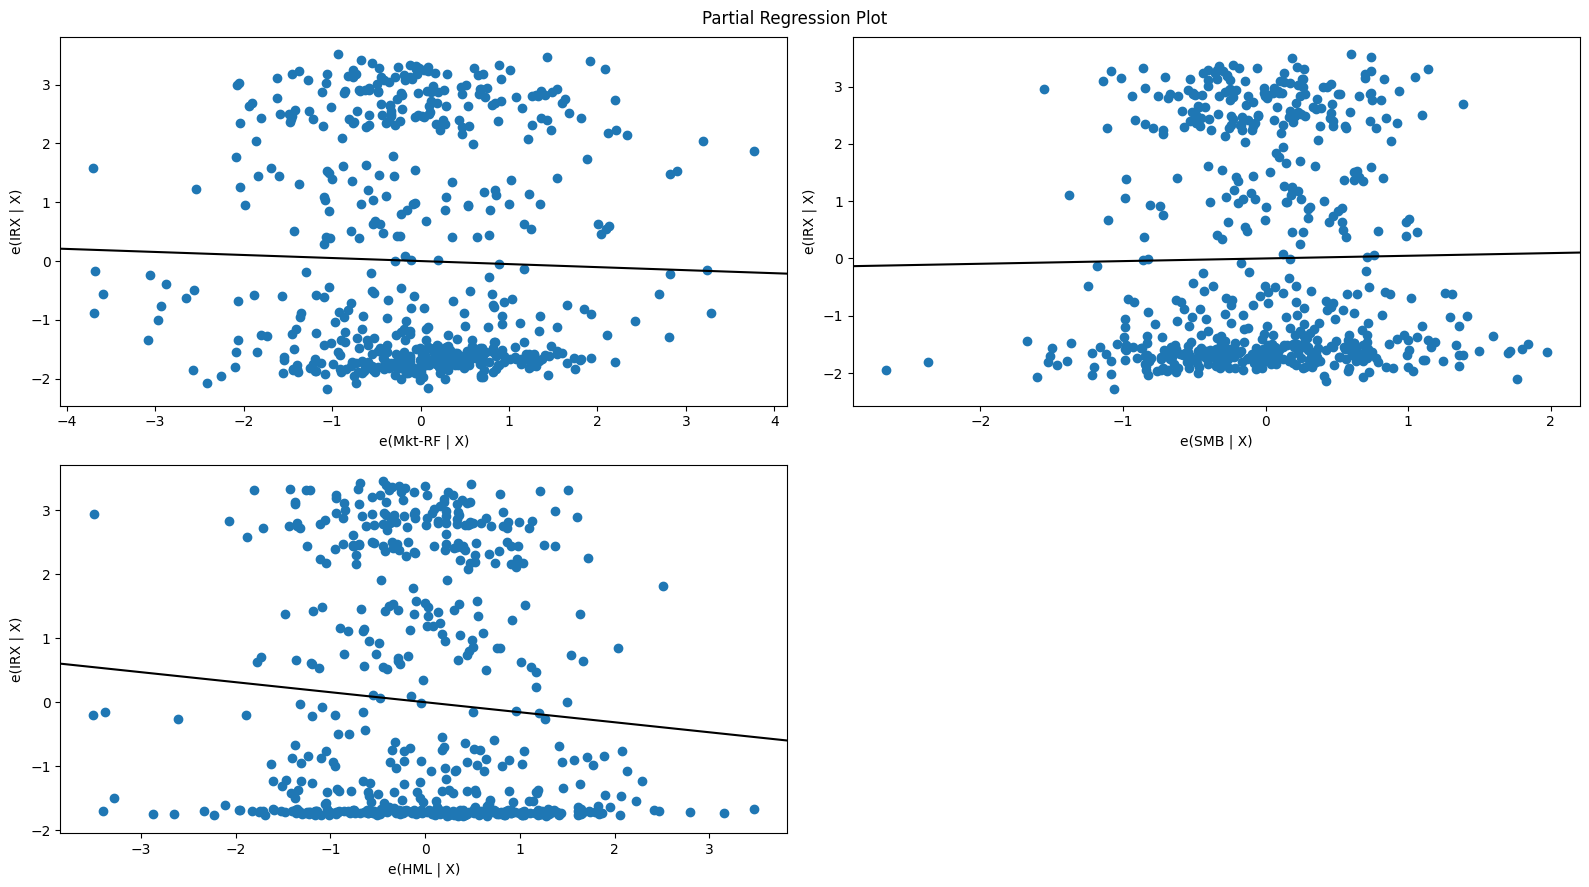

In [27]:
fig = plt.figure()
plot_partregress_grid(linear_regr_3_factors, exog_idx=[1,2,3], fig=fig)
plt.show()

### Robust regression

We will now regress the ^IRX index against the FF3 factors using a robust regression model(*M-Estimation*), in order to gain a better appreciation of the influence of outlying data points over the analysis.

We will leave the train-test split of the dataset at a 75/25 ratio.

In [28]:
X_train, X_test, Y_train, Y_test = trainTestSplit(factors_FF3, test_set)

In [29]:
# train the robust regression model ^IRX = Huber(FF3)
X_train = sm.add_constant(X_train)
robust_norm = [sm.robust.norms.HuberT(), sm.robust.norms.TukeyBiweight()]
robust_regr_3_factors_model = []
robust_regr_3_factors = []
robust_train_params = []
for i in range(len(robust_norm)):
    robust_regr_3_factors_model.append(sm.RLM(endog=Y_train, exog=X_train, M=robust_norm[i]))
    robust_regr_3_factors.append(robust_regr_3_factors_model[i].fit())
    robust_train_params.append(robust_regr_3_factors[i].params)
    print(robust_regr_3_factors[i].summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                    IRX   No. Observations:                  567
Model:                            RLM   Df Residuals:                      563
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 03 May 2024                                         
Time:                        03:40:17                                         
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7554      0.082     21.438      0.0

In [30]:
print("Huber parameters:\n",robust_train_params[0])
print("Bisquare parameters:\n",robust_train_params[1])

Huber parameters:
 const     1.755371
Mkt-RF   -0.052250
SMB       0.045692
HML      -0.157307
dtype: float64
Bisquare parameters:
 const     1.686766
Mkt-RF   -0.055997
SMB       0.052957
HML      -0.161241
dtype: float64


In [34]:
robust_regr_FF3_train = robust_regr_3_factors_model[0].predict(robust_train_params[0])
#training_time = df_daily.index[:train_set]
print(len(training_time), len(robust_regr_FF3_train), len(Y_train))

567 567 567


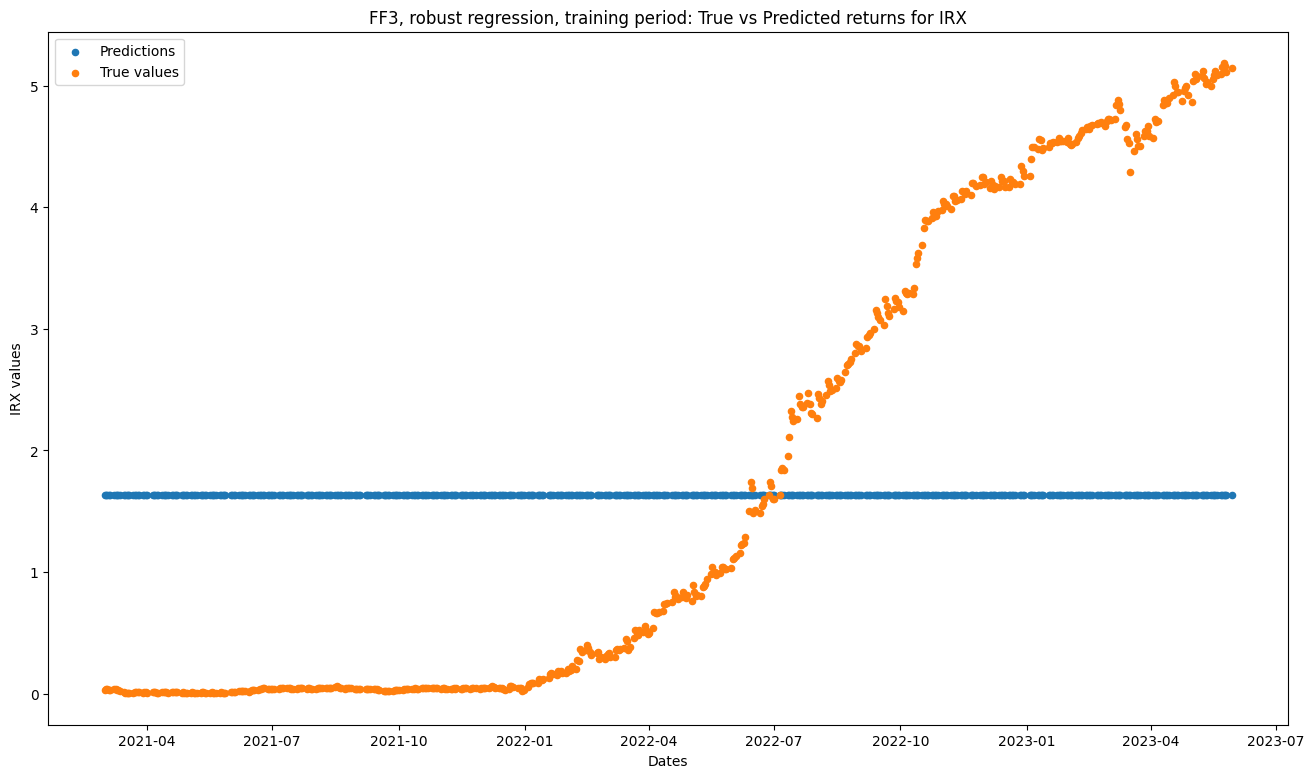

In [35]:
df_training_predictions_robust_FF3 = pd.DataFrame(
    {"Date": training_time, "Predictions": robust_regr_FF3_train[0], "True values": Y_train}
)

plt.figure()
ax = plt.gca()
df_training_predictions_robust_FF3.plot.scatter(x="Date", y="Predictions", c='tab:blue', label='Predictions', ax=ax)
df_training_predictions_robust_FF3.plot.scatter(x="Date", y="True values", c='tab:orange', label='True values', ax=ax)
# time_on_x = df_training_predictions_FF3["Date"] - df_training_predictions_FF3["Date"].min()#.apply(lambda x: x.date()))#.astype(np.int64)
# time_on_x = time_on_x.astype(np.int64) * 1E-12
# (a, b) = np.polyfit(time_on_x, df_training_predictions_FF3["Predictions"], 1)
# plt.plot(time_on_x, a * time_on_x + b, label="best regression fit line")
ax.set_xlabel('Dates')
ax.set_ylabel("IRX values")
plt.legend()
plt.title("FF3, robust regression, training period: True vs Predicted returns for IRX")
plt.show()

In [36]:
robust_regr_FF3_test = robust_regr_3_factors[0].predict(sm.add_constant(X_test, has_constant='add')) # added alpha coefficient
#testing_time = df_daily.index[train_set:]
print(len(testing_time), len(robust_regr_FF3_test), len(Y_test))

188 188 188


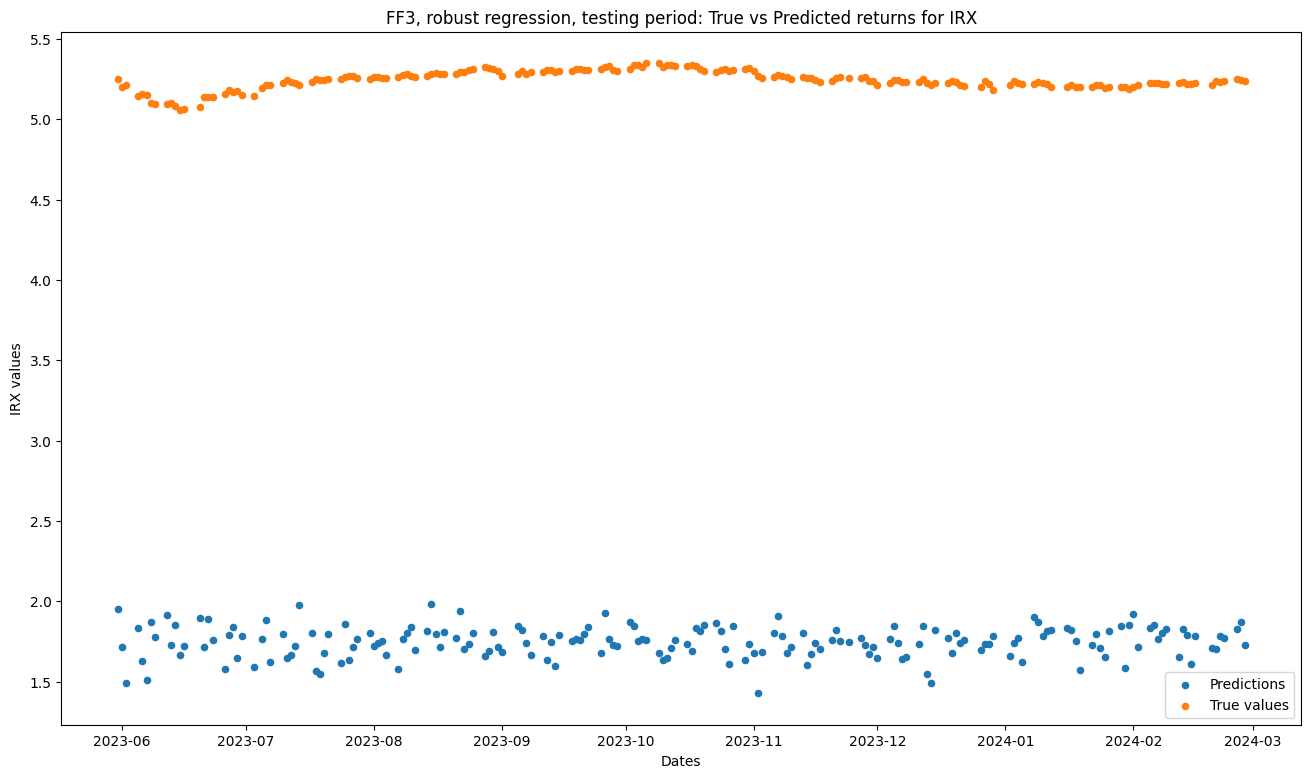

In [37]:
df_testing_predictions_robust_FF3 = pd.DataFrame(
    {"Date": testing_time, "Predictions": robust_regr_FF3_test, "True values": Y_test}
)

plt.figure()
ax = plt.gca()
df_testing_predictions_robust_FF3.plot.scatter(x="Date", y="Predictions", c='tab:blue', label='Predictions', ax=ax)
df_testing_predictions_robust_FF3.plot.scatter(x="Date", y="True values", c='tab:orange', label='True values', ax=ax)
plt.legend()
ax.set_xlabel('Dates')
ax.set_ylabel("IRX values")
plt.title("FF3, robust regression, testing period: True vs Predicted returns for IRX")
plt.show()

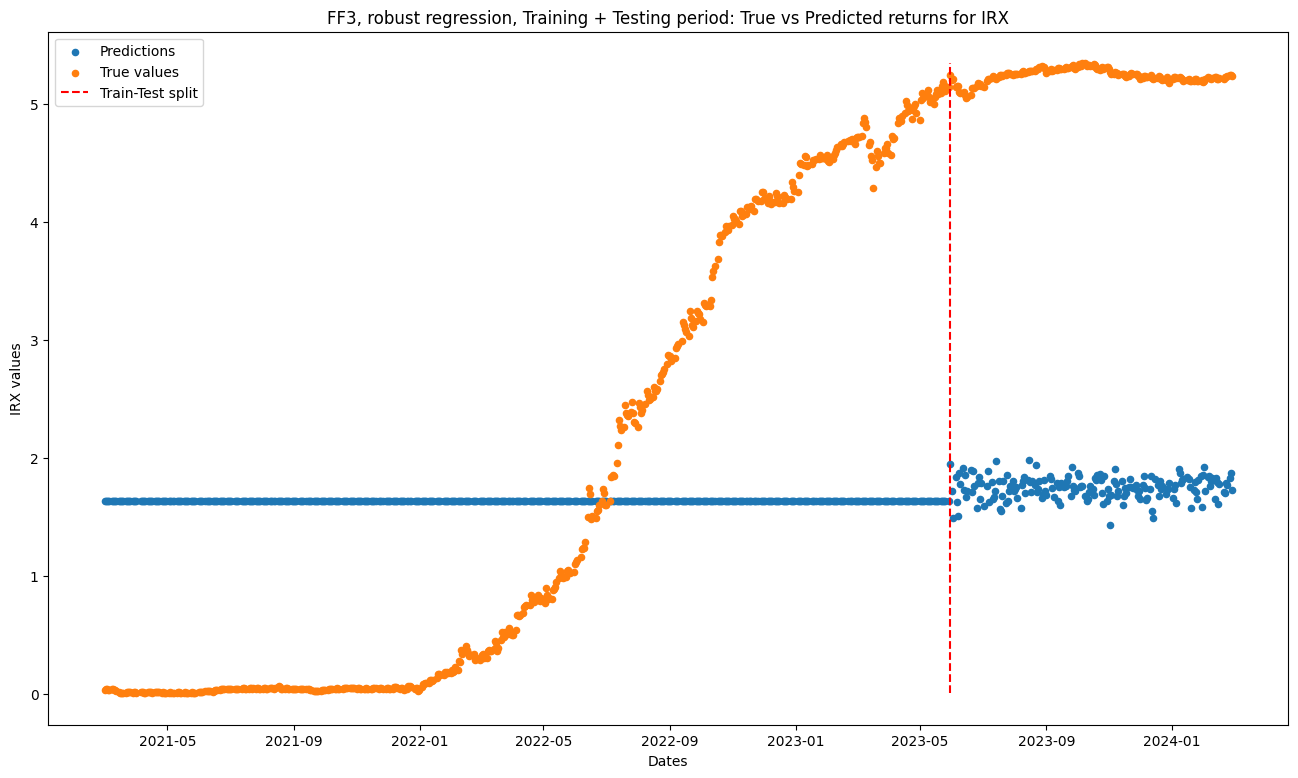

In [38]:
FF3_robust_predictions = pd.concat([df_training_predictions_robust_FF3, df_testing_predictions_robust_FF3],
    keys=['training', 'testing'],
    ignore_index=True                          
)

plt.figure()
ax = plt.gca()
FF3_robust_predictions.plot.scatter(x="Date", y="Predictions", c='tab:blue', label='Predictions', ax=ax)
FF3_robust_predictions.plot.scatter(x="Date", y="True values", c='tab:orange', label='True values', ax=ax)
plt.vlines(x=df_testing_predictions_robust_FF3["Date"].iloc[0], 
           ymin=FF3_robust_predictions["True values"].min(), 
           ymax=FF3_robust_predictions["True values"].max(), 
           colors="r", 
           linestyles="dashed",
           label="Train-Test split"
)
plt.legend()
ax.set_xlabel('Dates')
ax.set_ylabel("IRX values")
plt.title("FF3, robust regression, Training + Testing period: True vs Predicted returns for IRX")
plt.show()

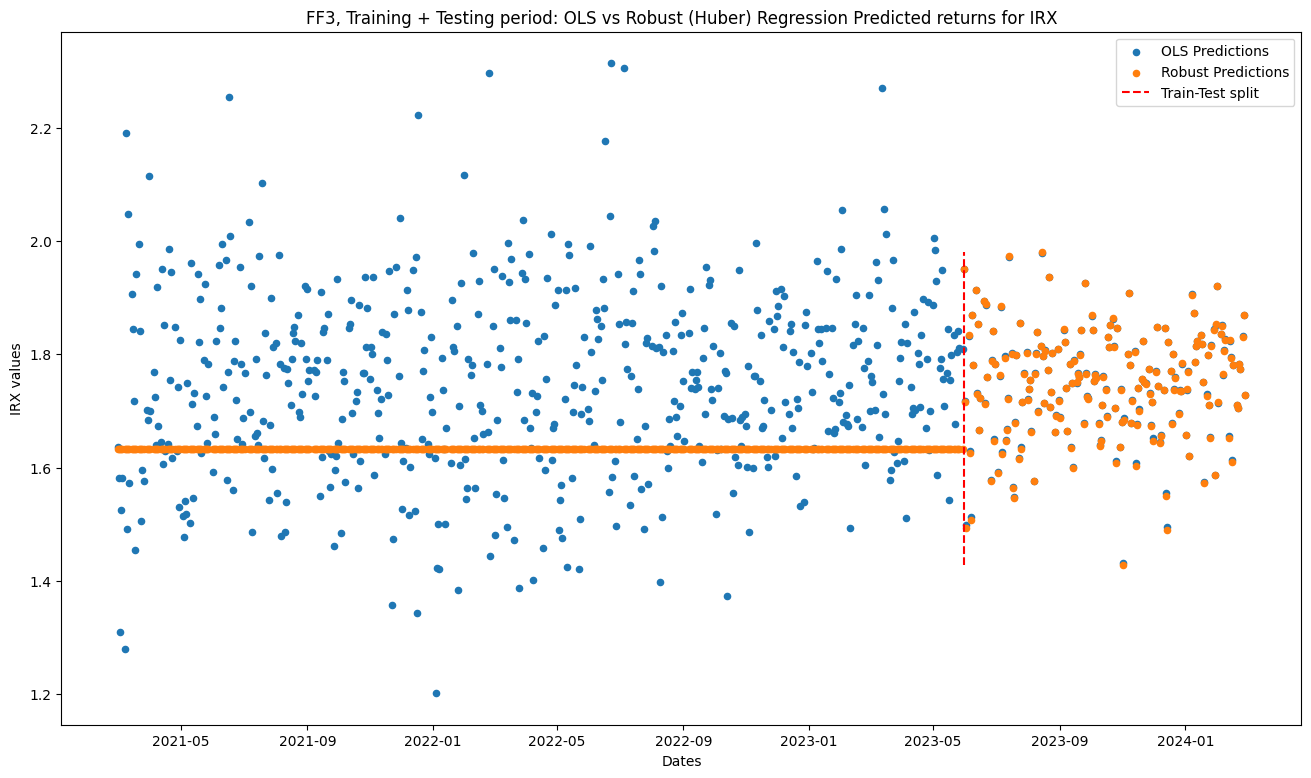

In [39]:
plt.figure()
ax = plt.gca()
FF3_LS_predictions.plot.scatter(x="Date", y="Predictions", c='tab:blue', label='OLS Predictions', ax=ax)
FF3_robust_predictions.plot.scatter(x="Date", y="Predictions", c='tab:orange', label='Robust Predictions', ax=ax)
plt.vlines(x=df_testing_predictions_robust_FF3["Date"].iloc[0], 
           ymin=FF3_robust_predictions["Predictions"].min(), 
           ymax=FF3_robust_predictions["Predictions"].max(), 
           colors="r", 
           linestyles="dashed",
           label="Train-Test split"
)
plt.legend()
ax.set_xlabel('Dates')
ax.set_ylabel("IRX values")
plt.title("FF3, Training + Testing period: OLS vs Robust (Huber) Regression Predicted returns for IRX")
plt.show()

The graph shown above - comparing regressions yielded by the ordinary least squares method against the robust Huber method - reveals results that are almost identical.
Robust regression mainly dampens the deleterious effects of outliers, so the above results exclude that the low quality of the regression is due to the impact of outliers.

But it was already evident that the bad fitting of the analysis is due to the short rates tracked by ^IRX being independent from the Fama-French factors, which is tailored to track market data, not macroeconomic ones.

Below, for this model we plot the partial regression lines of the dependent variable, ^IDX, against each of the three independent variables of the FF3 model.
The lines are obtained by plotting residuals of ^IRX against residuals of each factor, after having removed the effect of the after factors.

The first figure below depicts partial regressions based on the Huber norm, while the second picture is based on the bisquare norm.

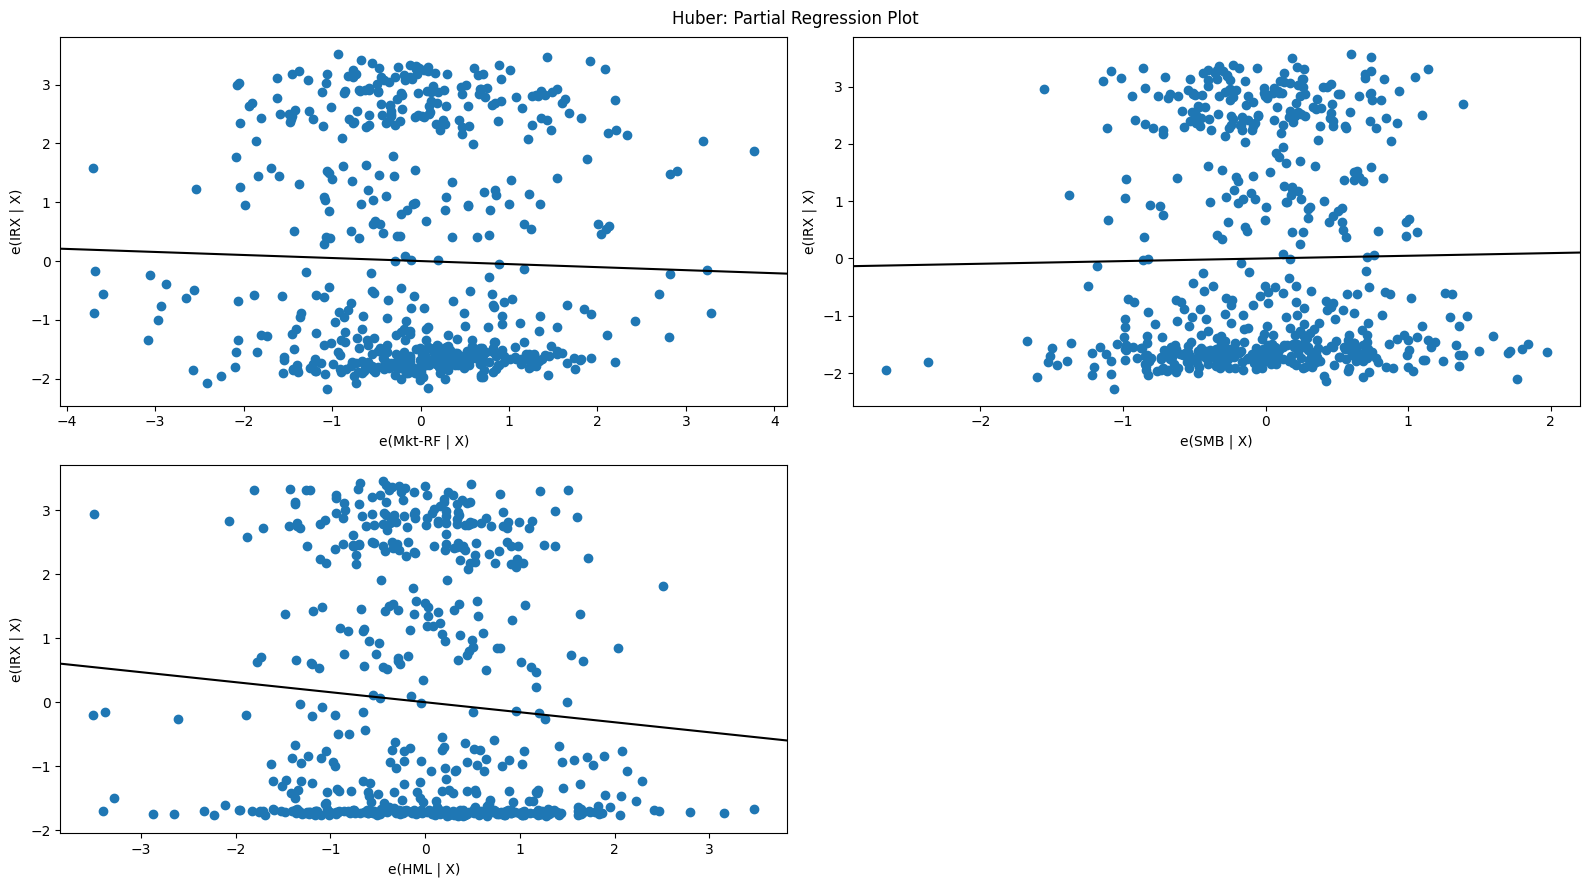

In [40]:
fig = plt.figure()
plot_partregress_grid(robust_regr_3_factors[0], exog_idx=[1,2,3], fig=fig)
plt.suptitle("Huber: Partial Regression Plot")
plt.show()

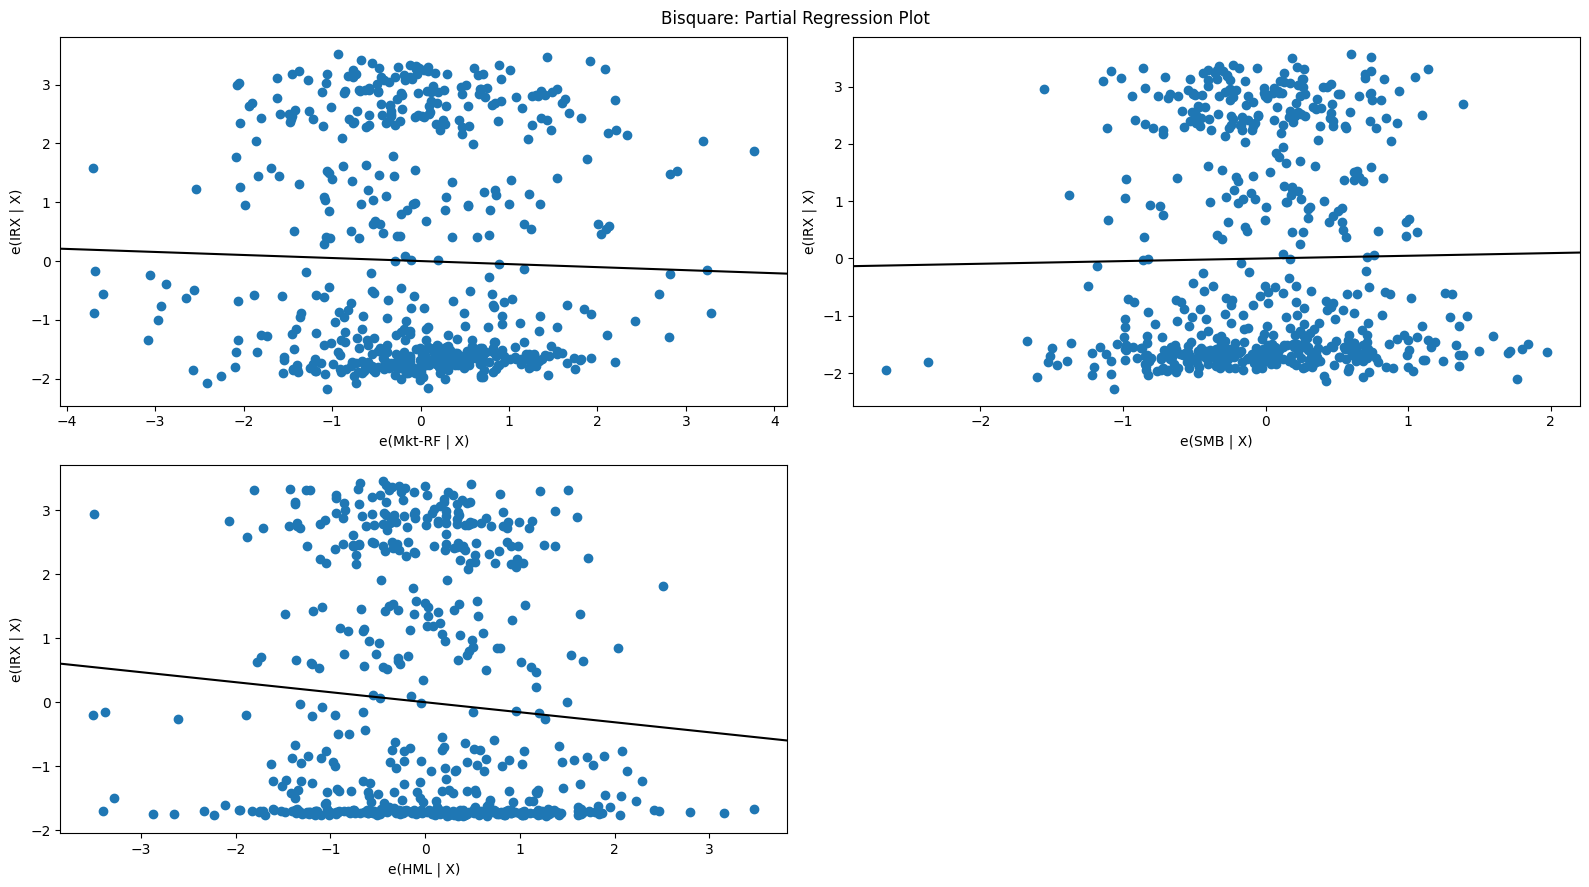

In [41]:
fig = plt.figure()
plot_partregress_grid(robust_regr_3_factors[1], exog_idx=[1,2,3], fig=fig)
plt.suptitle("Bisquare: Partial Regression Plot")
plt.show()

## b. Provide summaries of coefficients and metrics for the model

We provide a summary of the analysis below.

Refer to the equation below for naming parameters in the regression:

$$
\text{IRX} = \alpha + \beta_0 \, (\text{Mkt-RF}) + \beta_1 \, (\text{SMB}) + \beta_2 \, (\text{HML})
$$

Summary of coefficients, with associated $p$-value in subsequent row.

| Model            | $\boldsymbol{\alpha}$    | $\boldsymbol{\beta_0}$    | $\boldsymbol{\beta_1}$    | $\boldsymbol{\beta_2}$   |
| ---------------- | ----------- |  ----------- | ------------ | ----------- |
| OLS              |   1.7562    |   -0.0516    |    0.0466    |   -0.1565   | 
| OLS $p$-value    |   0.000    |    0.481    |    0.708     |    0.048   |
| Robust Huber     |   1.7554    |   -0.0522    |    0.0457    |   -0.1565   | 
| Huber $p$-value  |   0.000    |   -0.479    |    0.716     |   0.048   | 
| Robust Bisquared |   1.6869    |   -0.0560    |    0.0530    |   -0.1612   |
| Bisqu. $p$-value |   0.000    |   -0.482    |    0.695     |   0.06   |

We can appreciate from the table above that for all models, only a weakly significant dependence of IRX from factor HML can be theorised. 
The table omits to report the standard deviation for the coefficients, in order to avoid data cluttering on parameters that in any case are not meaningful.

Summary of metrics for the OLS regression (values for the robust regressions are probably equal or very close, which would presumably be why no statistical metrics are available for them inside the ```statsmodels``` package).

| Model            | $\boldsymbol{R^2}$    | $\bf{\text{adj }} \boldsymbol{R^2}$    | $\bf{Jarque Bera}$   |
| ---------------- | --------------------- |  -------------------------------- | ---------------------------- |
| OLS              |   0.007    |   0.002    |    74.664   | 

$R^2$-based statistics close to 0 indicates that almost none of the variance in the dependent variable can be explained by the exogenous factors.
The Jarque-Bera test result is far from 0, which means the dependent variable is not normally distributed.

# Step 4

Find the beta factors in the FF5 model

## a. Run both Least Squares and robust regressions on the data, and describe the train-test split.

### Least Squares regression

### Robust regression

## b. Provide summaries of coefficients and metrics for the model

# Step 5

## c. Correlation matrix of factor returns

Below, we repeat the computation of the correlation matrix between the 5 factors in the Fama-French model.

In [42]:
# Compute the correlation matrix of factor returns
correlation_matrix = df_daily.corr()

# Display the correlation matrix
print("Correlation Matrix of Factor Returns:")
print(correlation_matrix)


Correlation Matrix of Factor Returns:
          Mkt-RF       SMB       HML       RMW       CMA        RF       IRX
Mkt-RF  1.000000  0.243558 -0.363329 -0.352298 -0.467209  0.025613  0.024057
SMB     0.243558  1.000000  0.104490 -0.430344 -0.040784  0.003388  0.005844
HML    -0.363329  0.104490  1.000000  0.434457  0.757473 -0.051910 -0.059177
RMW    -0.352298 -0.430344  0.434457  1.000000  0.389915 -0.044879 -0.046048
CMA    -0.467209 -0.040784  0.757473  0.389915  1.000000 -0.078295 -0.086563
RF      0.025613  0.003388 -0.051910 -0.044879 -0.078295  1.000000  0.986712
IRX     0.024057  0.005844 -0.059177 -0.046048 -0.086563  0.986712  1.000000


Now Visualizing the Correlation Matrix of Factor Returns

### 1. Heatmap

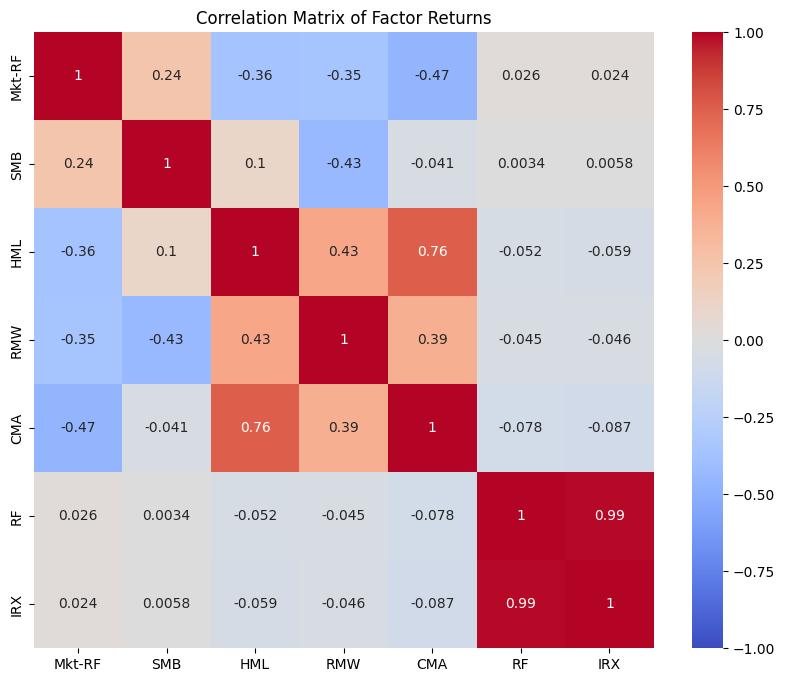

In [43]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Factor Returns')
plt.show()


A heatmap is an effective way to visualize the correlation matrix using colors to represent the correlation coefficients. The color palette of the heatmap shows, warmer colors represent positive correlations and cooler colors represent negative correlations.

### 2. Pairplot

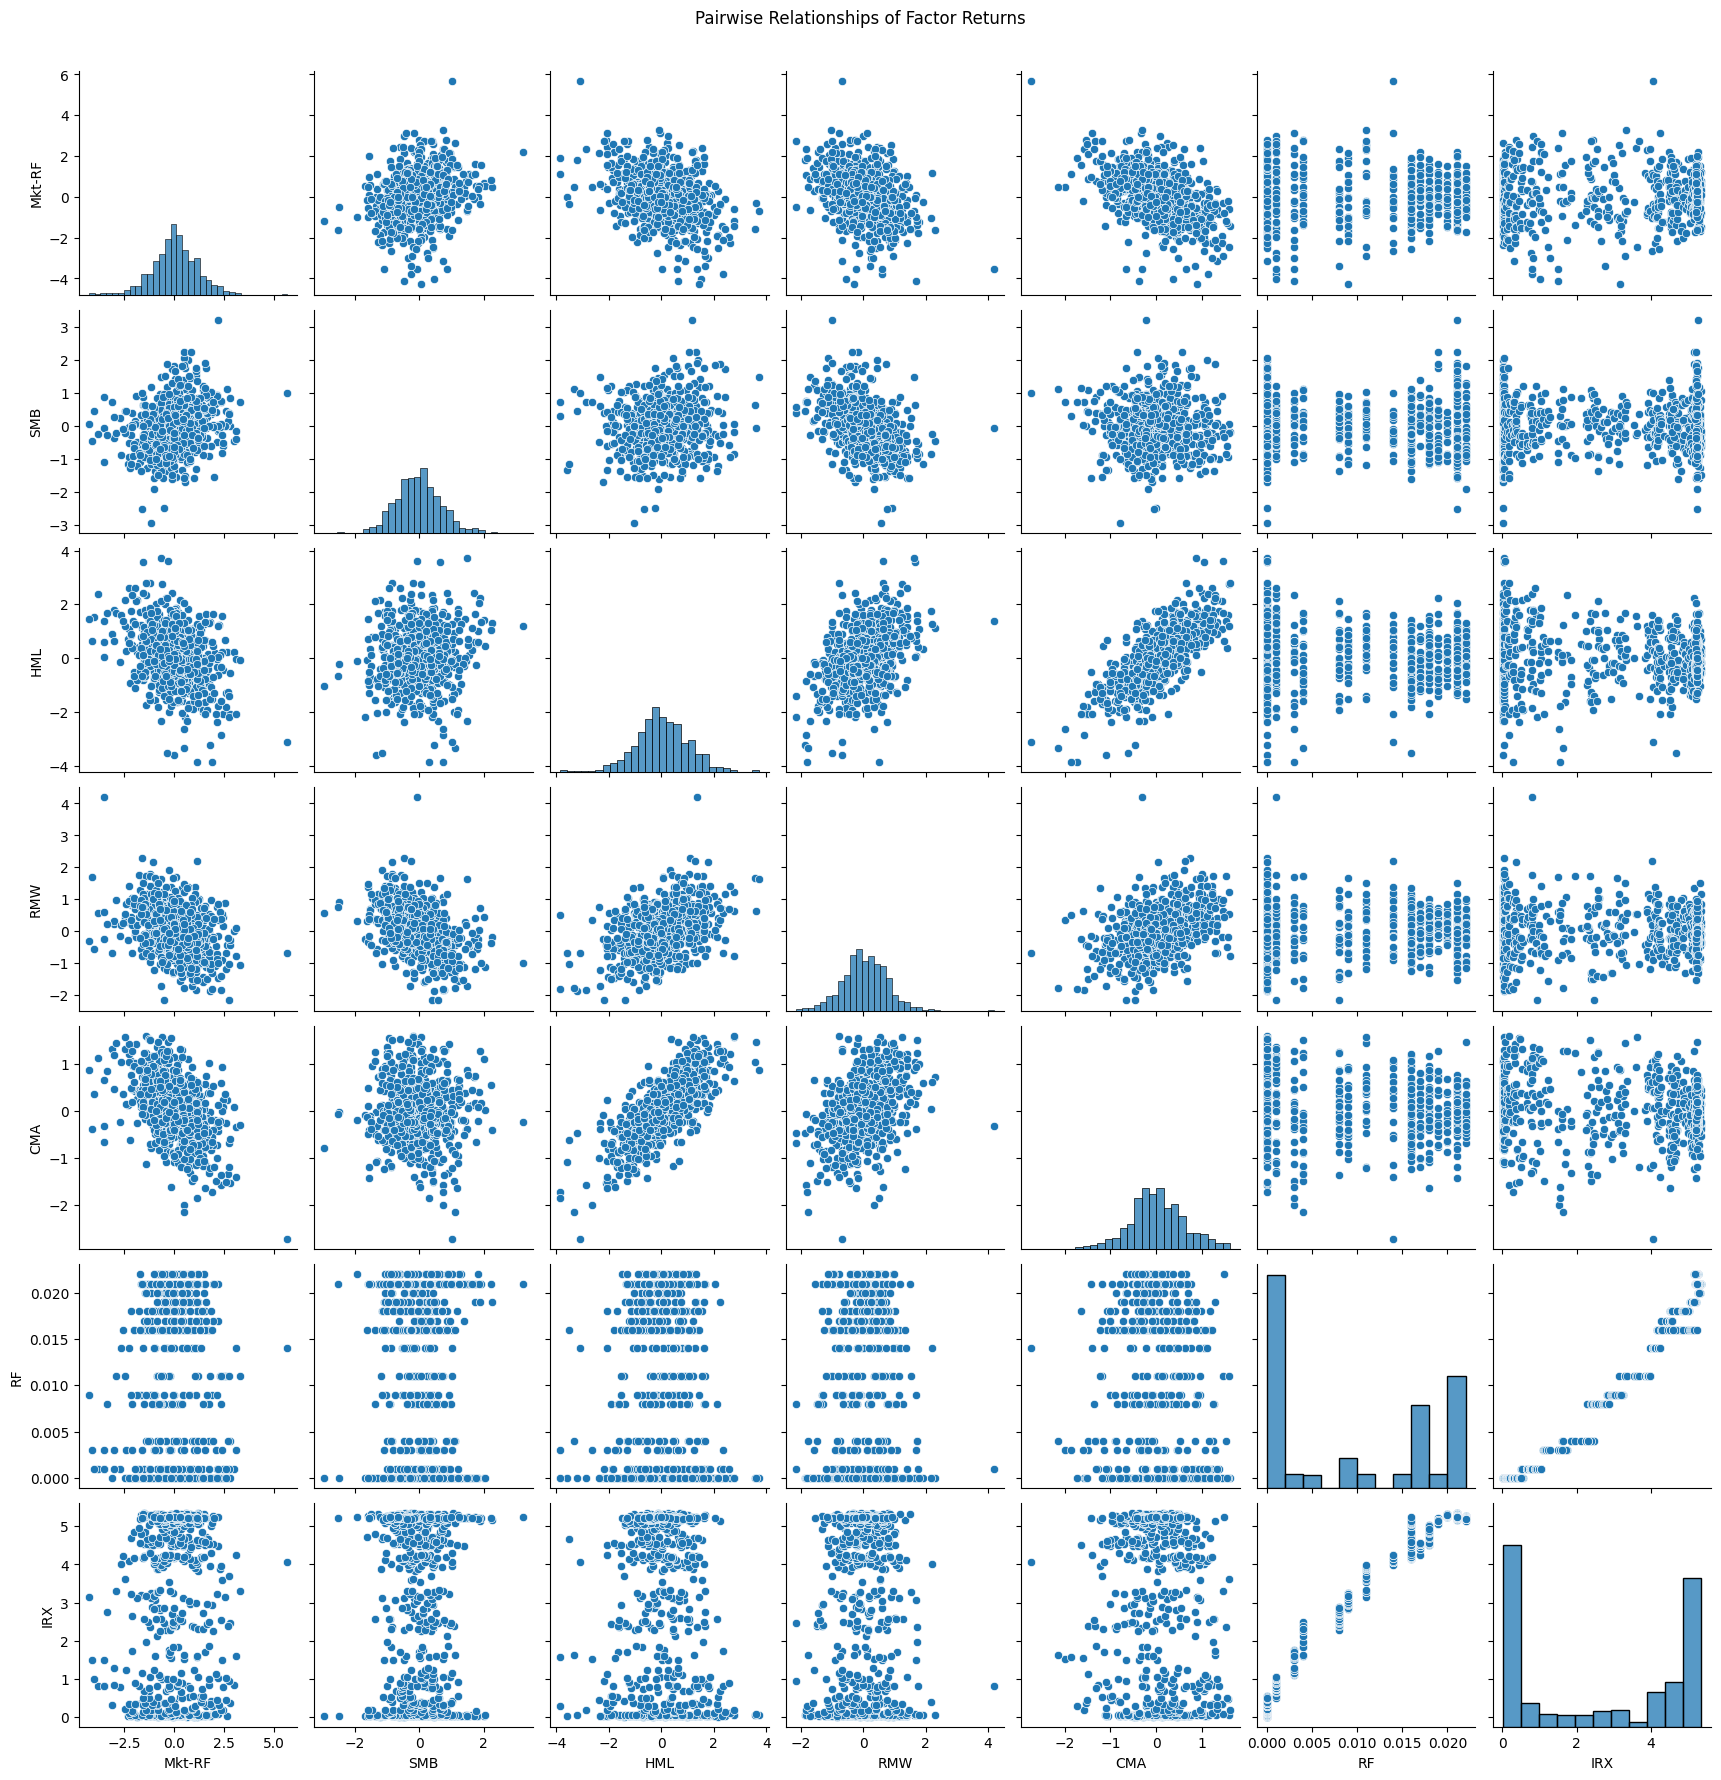

In [44]:
# Plot pairwise relationships in the DataFrame
sns.pairplot(df_daily)
plt.suptitle('Pairwise Relationships of Factor Returns', y=1.02)
plt.show()

A pairplot is used to visualize pairwise relationships between different factors. The grid of scatterplots for each pair of factors, showing their relationships along with histograms for each individual factor.

### 3. Clustermap

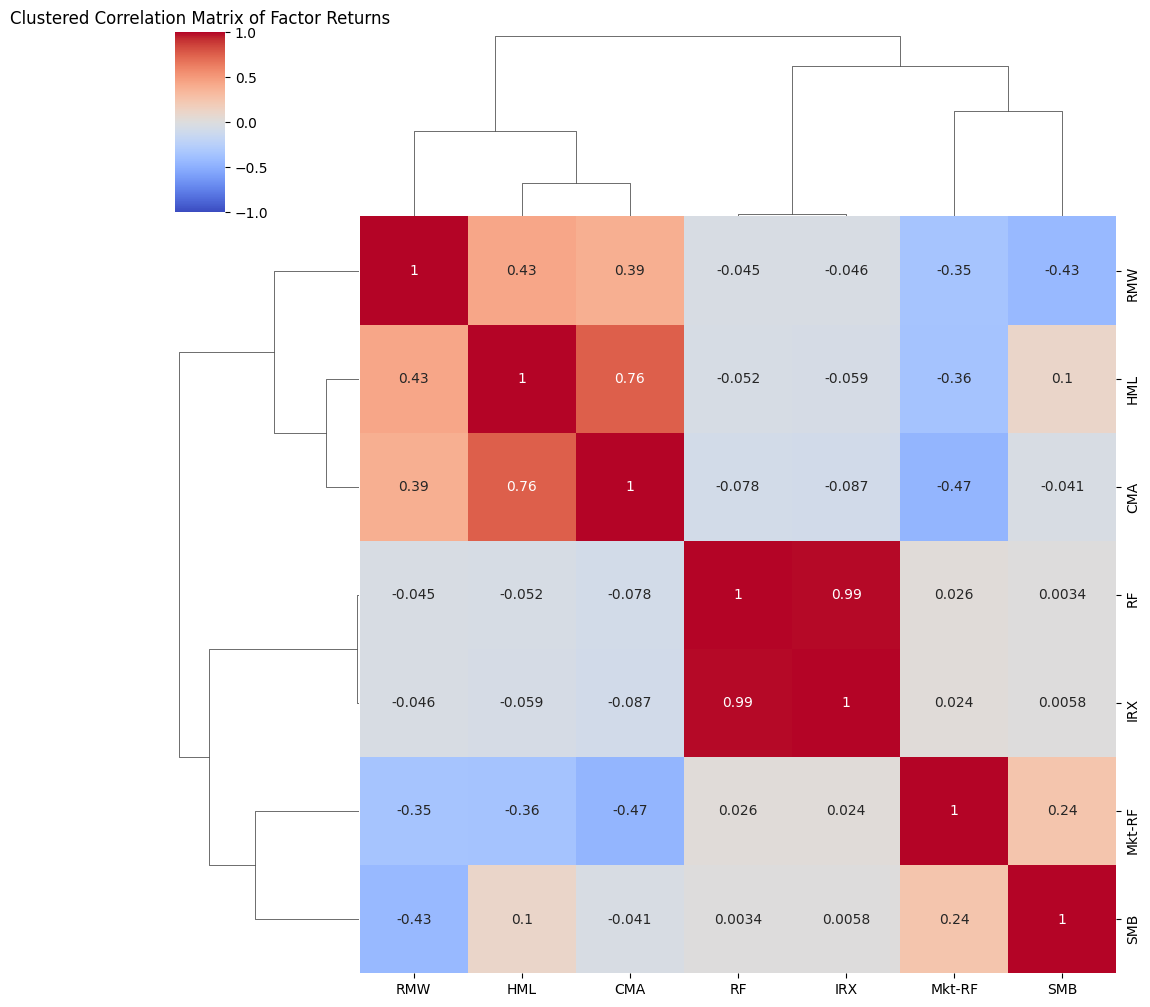

In [45]:
# Create a clustermap of the correlation matrix
sns.clustermap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Clustered Correlation Matrix of Factor Returns')
plt.show()

The clustermap visually organizes similar factors into clusters based on their correlation coefficients.

## d. Covariance Matrix of Factor Returns

In [46]:
# Load your DataFrame with factor returns
# Assuming df contains the factor returns data

# Compute the covariance matrix
covariance_matrix = df_daily.cov()

# Display the covariance matrix
print("Covariance Matrix of Factor Returns:")
print(covariance_matrix)


Covariance Matrix of Factor Returns:
          Mkt-RF       SMB       HML       RMW       CMA        RF       IRX
Mkt-RF  1.335694  0.203341 -0.435558 -0.290114 -0.334401  0.000266  0.062662
SMB     0.203341  0.521839  0.078295 -0.221508 -0.018246  0.000022  0.009514
HML    -0.435558  0.078295  1.075930  0.321103  0.486589 -0.000484 -0.138342
RMW    -0.290114 -0.221508  0.321103  0.507705  0.172060 -0.000287 -0.073949
CMA    -0.334401 -0.018246  0.486589  0.172060  0.383537 -0.000436 -0.120822
RF      0.000266  0.000022 -0.000484 -0.000287 -0.000436  0.000081  0.019980
IRX     0.062662  0.009514 -0.138342 -0.073949 -0.120822  0.019980  5.079527


## e. Comparison of the Two matrices

Correlation and covariance matrix for factors in the Fama-French model during timeframe specified (March 2021 - February 2024).

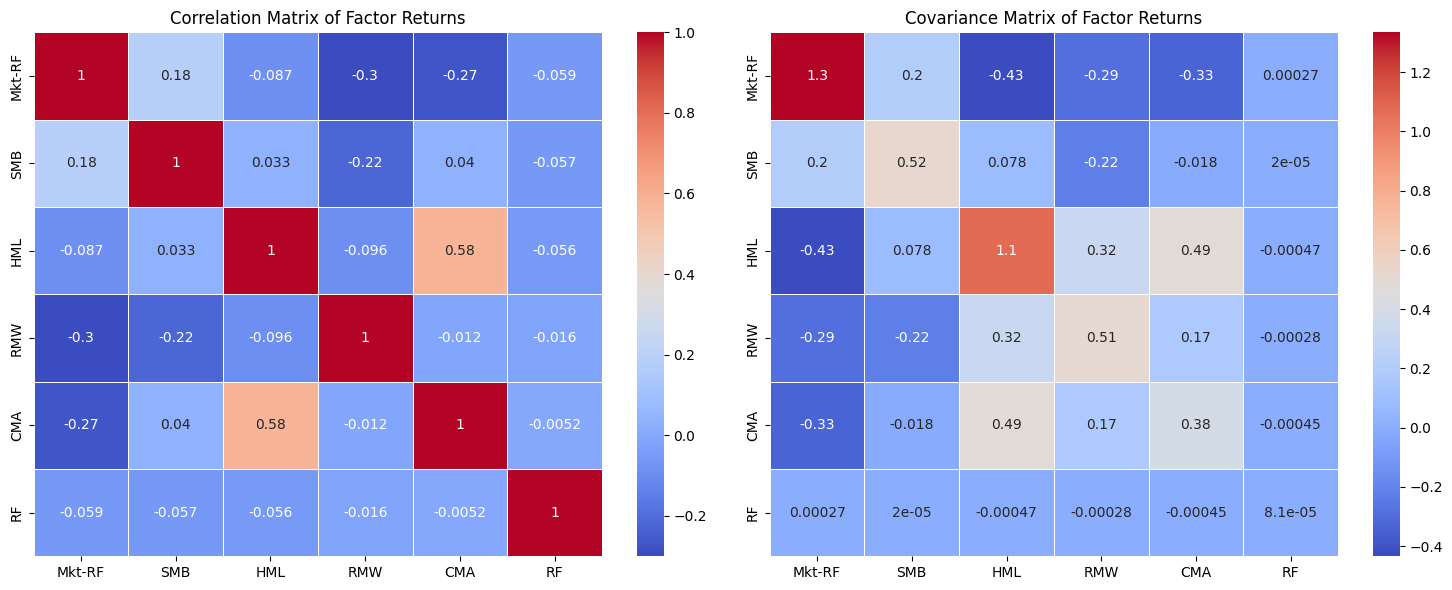

In [47]:
# Assuming df_correlation and df_covariance are your computed matrices
# Create sample correlation and covariance matrices for demonstration
df_correlation = pd.DataFrame({
    'Mkt-RF': [1.000000, 0.184681, -0.087465, -0.300522, -0.272049, -0.059037],
    'SMB': [0.184681, 1.000000, 0.032719, -0.222612, 0.039643, -0.056948],
    'HML': [-0.087465, 0.032719, 1.000000, -0.096202, 0.582800, -0.055961],
    'RMW': [-0.300522, -0.222612, -0.096202, 1.000000, -0.011507, -0.016484],
    'CMA': [-0.272049, 0.039643, 0.582800, -0.011507, 1.000000, -0.005166],
    'RF': [-0.059037, -0.056948, -0.055961, -0.016484, -0.005166, 1.000000]
}, index=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'])

df_covariance = pd.DataFrame({
    'Mkt-RF': [1.334268,  0.202983, -0.434340, -0.289578, -0.334463,  0.000273],
    'SMB': [0.202983,  0.521171,  0.078026, -0.221254, -0.018091,  0.000020],
    'HML': [-0.434340,  0.078026,  1.075704,  0.320962,  0.485003, -0.000468],
    'RMW': [-0.289578, -0.221254,  0.320962,  0.507100,  0.171608, -0.000283], 
    'CMA': [-0.334463, -0.018091,  0.485003,  0.171608,  0.383770, -0.000447],
    'RF': [0.000273,  0.000020, -0.000468, -0.000283, -0.000447,  0.000081]
}, index=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'])

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the correlation matrix
sns.heatmap(df_correlation, annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Matrix of Factor Returns')

# Plot the covariance matrix
sns.heatmap(df_covariance, annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Covariance Matrix of Factor Returns')

# Adjust layout
plt.tight_layout()
plt.show()


Correlation Matrix:
The correlation matrix measures the linear relationship between pairs of factors, normalized to a scale of -1 to 1.
Values closer to 1 indicate a strong positive linear relationship, while values closer to -1 indicate a strong negative linear relationship.
The diagonal elements are always 1, indicating perfect correlation of a factor with itself.
Example: The correlation between Mkt-RF and SMB is 0.184681, suggesting a weak positive linear relationship.

Covariance Matrix:
The covariance matrix measures the extent to which two factors move together, regardless of the scale of their values.
Larger values indicate greater variability between the factors, while values closer to zero indicate less variability.
The diagonal elements represent the variance of each factor.
Example: The covariance between Mkt-RF and HML is -0.43434, indicating a negative covariance (opposite movement).

# Step 6 
Effects of CMA and RMW

In [48]:
# Define the dependent variable (e.g., 'Mkt-RF') and independent variables (factors)
dependent_variable = 'Mkt-RF'
independent_variables_all = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
independent_variables_subset = ['Mkt-RF', 'SMB', 'HML', 'RF']  # Subset without CMA and RMW

# Function to perform linear regression and return coefficients and model summary
def run_regression(df, dependent_variable, independent_variables):
    X = df[independent_variables]
    X = sm.add_constant(X)
    Y = df[dependent_variable]
    model = sm.OLS(Y, X)
    results = model.fit()
    return results

# Run regression with all factors (including CMA and RMW)
results_all_factors = run_regression(df_daily, dependent_variable, independent_variables_all)

# Run regression with subset of factors (excluding CMA and RMW)
results_subset_factors = run_regression(df_daily, dependent_variable, independent_variables_subset)

# Prepare a summary table to compare results
summary_table = pd.DataFrame({
    'Factors Included': ['All Factors (CMA & RMW)', 'Subset of Factors'],
    'R-squared': [results_all_factors.rsquared, results_subset_factors.rsquared],
    'Adjusted R-squared': [results_all_factors.rsquared_adj, results_subset_factors.rsquared_adj],
    'Coefficient Mkt-RF': [results_all_factors.params['Mkt-RF'], results_subset_factors.params['Mkt-RF']],
    'Coefficient SMB': [results_all_factors.params['SMB'], results_subset_factors.params['SMB']],
    'Coefficient HML': [results_all_factors.params['HML'], results_subset_factors.params['HML']],
    'Coefficient RF': [results_all_factors.params['RF'], results_subset_factors.params['RF']]
})

# Display the summary table
print("Regression Results - Impact of Additional Factors (CMA & RMW):\n")
print(summary_table)

Regression Results - Impact of Additional Factors (CMA & RMW):

          Factors Included  R-squared  Adjusted R-squared  Coefficient Mkt-RF  \
0  All Factors (CMA & RMW)        1.0                 1.0                 1.0   
1        Subset of Factors        1.0                 1.0                 1.0   

   Coefficient SMB  Coefficient HML  Coefficient RF  
0     2.749537e-16     1.951564e-18    1.151856e-15  
1    -6.320899e-17    -2.091426e-16    1.151856e-15  


# Step 7

## f. Markowitz portfolio optimization

In [55]:
# Define the list of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download historical stock prices from Yahoo Finance
start_date = '2021-03-01'
end_date = '2024-02-29'
stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Display the first few rows of the stock data
print(stock_data.head())

[*********************100%%**********************]  5 of 5 completed

Ticker            AAPL        AMZN       GOOGL        MSFT        TSLA
Date                                                                  
2021-03-01  125.599640  157.307007  103.483002  230.847687  239.476669
2021-03-02  122.975410  154.726501  103.223999  227.856644  228.813339
2021-03-03  119.967857  150.250000  100.570503  221.708893  217.733337
2021-03-04  118.070953  148.878494  101.696503  220.900208  207.146667
2021-03-05  119.338821  150.022995  104.853500  225.645020  199.316666


In [56]:
# Calculate daily returns
returns = stock_data.pct_change().dropna()

# Calculate expected returns (mean daily returns)
expected_returns = returns.mean()

# Calculate covariance matrix of returns
covariance_matrix = returns.cov()

# Display expected returns and covariance matrix
print("Expected Returns:")
print(expected_returns)
print("\nCovariance Matrix:")
print(covariance_matrix)


Expected Returns:
Ticker
AAPL     0.000633
AMZN     0.000406
GOOGL    0.000563
MSFT     0.000905
TSLA     0.000443
dtype: float64

Covariance Matrix:
Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
Ticker                                                  
AAPL    0.000291  0.000243  0.000229  0.000215  0.000328
AMZN    0.000243  0.000558  0.000310  0.000275  0.000391
GOOGL   0.000229  0.000310  0.000392  0.000250  0.000291
MSFT    0.000215  0.000275  0.000250  0.000302  0.000278
TSLA    0.000328  0.000391  0.000291  0.000278  0.001339


In [51]:
# Define the list of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download historical stock prices from Yahoo Finance
start_date = '2021-03-01'
end_date = '2024-02-29'
stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = stock_data.pct_change().dropna()

# Calculate expected returns and covariance matrix
expected_returns = returns.mean()
covariance_matrix = returns.cov()

# Number of assets (stocks)
num_assets = len(tickers)

# Define the variables (portfolio weights)
weights = cp.Variable(num_assets)

# Define the risk-free rate (annualized)
risk_free_rate = 0.0

# Define the target return
target_return = 0.10  # Example target return of 10% per year (adjust as needed)

# Define the objective function (minimize portfolio volatility)
portfolio_variance = cp.quad_form(weights, covariance_matrix.values)
objective = cp.Minimize(portfolio_variance)

# Define the constraints
constraints = [
    cp.sum(weights) == 1,  # Fully invested (sum of weights = 1)
    expected_returns.values @ weights >= target_return  # Target minimum expected return
]

# Create the optimization problem
optimization_problem = cp.Problem(objective, constraints)

# Solve the optimization problem
optimization_problem.solve()

# Get the optimal asset allocation weights
optimal_weights = weights.value

# Display optimal asset allocation weights
print("Optimal Asset Allocation Weights:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.4f}")

# Calculate and display optimal portfolio expected return and volatility
optimal_portfolio_return = expected_returns.values @ optimal_weights
optimal_portfolio_volatility = np.sqrt(portfolio_variance.value)
print("\nOptimal Portfolio:")
print(f"Target Return: {target_return:.2%}")
print(f"Expected Return: {optimal_portfolio_return:.2%}")
print(f"Volatility (Risk): {optimal_portfolio_volatility:.2%}")


[*********************100%%**********************]  5 of 5 completed

Optimal Asset Allocation Weights:
AAPL: -66.7592
MSFT: -97.5329
GOOGL: -80.1574
AMZN: 255.8507
TSLA: -10.4012

Optimal Portfolio:
Target Return: 10.00%
Expected Return: 10.00%
Volatility (Risk): 289.86%


## g. Portfolio dependence from factors in FF3

In [52]:
# Fama-French 3-factor model data (Market, SMB, HML)
try:
    ff_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
    ff_returns = pd.DataFrame(ff_data).pct_change().dropna()
    ff_returns = ff_returns.rename(columns={'Adj Close': '^GSPC'})
    
    # Calculate factor returns (excess returns over risk-free rate)
    ff_returns['RF'] = 0.0  # Assuming risk-free rate is zero for simplicity
    ff_returns['Mkt-RF'] = ff_returns['^GSPC'] - ff_returns['RF']
    ff_returns['SMB'] = returns['AMZN'] - returns['TSLA']  # Example calculation for SMB
    ff_returns['HML'] = returns['AAPL'] - returns['MSFT']  # Example calculation for HML 
    
except KeyError:
    print("Error: S&P 500 index (^GSPC) data not available.")
    # Handle the error gracefully or use an alternative data source
# Calculate expected returns and covariance matrix
expected_returns = returns.mean()
covariance_matrix = returns.cov()

# Number of assets (stocks)
num_assets = len(tickers)

# Define the variables (portfolio weights)
weights = cp.Variable(num_assets)

# Define the risk-free rate (annualized)
risk_free_rate = 0.0

# Define the target return
target_return = 0.10  # Example target return of 10% per year (adjust as needed)

# Define the objective function (minimize portfolio volatility)
portfolio_variance = cp.quad_form(weights, covariance_matrix.values)
objective = cp.Minimize(portfolio_variance)

# Define the constraints
constraints = [
    cp.sum(weights) == 1,  # Fully invested (sum of weights = 1)
    expected_returns.values @ weights >= target_return  # Target minimum expected return
]

# Create the optimization problem
optimization_problem = cp.Problem(objective, constraints)

# Solve the optimization problem
optimization_problem.solve()

# Get the optimal asset allocation weights
optimal_weights = weights.value

# Calculate and display optimal portfolio expected return and volatility
optimal_portfolio_return = expected_returns.values @ optimal_weights
optimal_portfolio_volatility = np.sqrt(portfolio_variance.value)
print("\nOptimal Portfolio:")
print(f"Target Return: {target_return:.2%}")
print(f"Expected Return: {optimal_portfolio_return:.2%}")
print(f"Volatility (Risk): {optimal_portfolio_volatility:.2%}")


[*********************100%%**********************]  1 of 1 completed


Optimal Portfolio:
Target Return: 10.00%
Expected Return: 10.00%
Volatility (Risk): 289.86%


## h. Portfolio dependence from factors in FF5

In [53]:
# Fama-French 5-factor model data (Market, SMB, HML, RMW, CMA)
try:
    # Calculate RMW, CMA using example calculations
    ff_returns['RMW'] = returns['GOOGL'] - returns['MSFT']
    ff_returns['CMA'] = returns['AAPL'] - returns['GOOGL']
    
except KeyError:
    print("Error: S&P 500 index (^GSPC) data not available.")
    # Handle the error gracefully or use an alternative data source
    
# Calculate expected returns and covariance matrix
expected_returns = returns.mean()
covariance_matrix = returns.cov()

# Number of assets (stocks)
num_assets = len(tickers)

# Define the variables (portfolio weights)
weights = cp.Variable(num_assets)

# Define the risk-free rate (annualized)
risk_free_rate = 0.0

# Define the target return
target_return = 0.10  # Example target return of 10% per year (adjust as needed)

# Define the objective function (minimize portfolio volatility)
portfolio_variance = cp.quad_form(weights, covariance_matrix.values)
objective = cp.Minimize(portfolio_variance)

# Define the constraints
constraints = [
    cp.sum(weights) == 1,  # Fully invested (sum of weights = 1)
    expected_returns.values @ weights >= target_return  # Target minimum expected return
]

# Create the optimization problem
optimization_problem = cp.Problem(objective, constraints)

# Solve the optimization problem
optimization_problem.solve()

# Get the optimal asset allocation weights
optimal_weights = weights.value

# Calculate and display optimal portfolio expected return and volatility
optimal_portfolio_return = expected_returns.values @ optimal_weights
optimal_portfolio_volatility = np.sqrt(portfolio_variance.value)
print("\nOptimal Portfolio:")
print(f"Target Return: {target_return:.2%}")
print(f"Expected Return: {optimal_portfolio_return:.2%}")
print(f"Volatility (Risk): {optimal_portfolio_volatility:.2%}")


Optimal Portfolio:
Target Return: 10.00%
Expected Return: 10.00%
Volatility (Risk): 289.86%


In [54]:
ff_returns

,^GSPC,RF,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,,,
2021-03-02,-0.008081,0.0,-0.008081,0.028123,-0.007937,0.010454,-0.018391
2021-03-03,-0.013066,0.0,-0.013066,0.019492,0.002524,0.001275,0.001250
2021-03-04,-0.013417,0.0,-0.013417,0.039494,-0.012164,0.014844,-0.027008
2021-03-05,0.019496,0.0,0.019496,0.045487,-0.010741,0.009564,-0.020305
2021-03-08,-0.005359,0.0,-0.005359,0.042282,-0.023495,-0.024534,0.001039
...,...,...,...,...,...,...,...
2024-02-22,0.021123,0.0,0.021123,0.021976,-0.012303,-0.012743,0.000441
2024-02-23,0.000348,0.0,0.000348,0.029905,-0.006852,0.002280,-0.009132
2024-02-26,-0.003787,0.0,-0.003787,-0.040190,-0.000628,-0.037564,0.036936
